# 1.0. - STEP ONE - UNDERSTANDING THE BUSINESS

The company is a health guarantee, looking to expand into Auto Insurance. Its business model is based on health policies, with an emphasis on quality of care. It faces fierce competition and sees expansion as a strategic opportunity. The project aims to predict customers' propensity to purchase Car Insurance, increasing revenue.

For further studies, consult the project PDF.

# 2.0. - STEP TWO - BUSINESS PROBLEM

The contracting insurer offers Health Insurance and now seek our help in creating a prediction model. The objective is to find out whether the beneficiaries of the previous year's health plan will also express interest in the new product that the company is launching, Auto Insurance.

Just like health insurance, car plan customers will need to pay an annual amount, known as a premium, and in the event of a vehicle accident, the guarantee will provide compensation to the consumer.

It depends on a survey of approximately 380,000 customers to assess their interest in adopting the new product. These responses were recorded in a database, along with other customer attributes.

The product team selected 127,000 new customers who did not respond to the survey to participate in a campaign. During the campaign, these customers confirmed offers for the new product. However, the offer will be made by the sales team through telephone calls. The sales team has limited capacity and can only make 20,000 calls during the campaign period.

In this context, the company is hiring a Data Science consultant to build a model that predicts whether or not the customer is interested in automobile insurance.

Therefore, our goal is to create a model that is delivered in a list and descending order format, whose customers are most likely to purchase the product.

This will allow the sales team to prioritize the people most interested in the product, optimizing the campaign and maximizing the company's revenue.

Key insights into the most relevant attributes of specific customers when purchasing car insurance.
• What percentage of specific customers purchasing auto insurance for the sales team will be able to reach 20,000 calls?
• If the sales team's capacity increases to 40,000 calls, what percentage of customers interested in purchasing auto insurance will the sales team be able to contact?
• How many calls does the sales team need to make to contact 80% of customers interested in purchasing auto insurance?

The data available on the Kaggle website, each line represents a customer and each column contains some attributes that describe this customer, in addition to their response to the survey, in which they are interested or not in the new insurance product.

# 3.0. - STEP THREE - DATA COLLECTION

## 3.1. - Imports:
In this section, all the necessary libraries and modules are imported. These libraries provide the required functionality for various data manipulation, visualization, and modeling tasks.

In [1]:
import pandas            as pd
import numpy             as np
import scikitplot        as skplt
import inflection
import boruta            as bt
import seaborn           as sns
import pickle 

from tabulate             import tabulate
from matplotlib           import pyplot          as plt
from sklearn              import model_selection as ms 
from sklearn              import metrics         as m
from scikitplot           import metrics         as mt
from sklearn              import preprocessing   as pp
from scipy                import stats           as ss
from sklearn              import ensemble        as en

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, balanced_accuracy_score, cohen_kappa_score, precision_score, recall_score, f1_score, matthews_corrcoef, roc_auc_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

from IPython.core.display import HTML
from IPython.core.display import Image
from sklearn.ensemble     import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV


import json
import pickle
import warnings

warnings.filterwarnings("ignore")

## 3.2. - Helper Functions:
This section contains several helper functions that will be used throughout the project to perform various tasks such as data pre-processing, error calculation and cross-validation. These functions help improve code organization and reuse.

In [2]:
def cramer_v( x, y ):
    # Calculate Cramer's V coefficient for two categorical variables.
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

def corr_cramer_v(cat_attributes):
    # Converte as colunas do DataFrame de atributos categóricos em uma lista
    cat_attributes_list = cat_attributes.columns.tolist()

    # Cria um dicionário vazio para armazenar a matriz de correlação
    corr_dict = {}

    # Loop para calcular a correlação entre todas as combinações de variáveis categóricas
    for i in range(len(cat_attributes_list)):
        # Lista vazia para armazenar as correlações da variável de referência
        corr_list = []
        for j in range(len(cat_attributes_list)):
            # Seleciona a variável de referência e a variável alvo
            ref = cat_attributes_list[i]
            feat = cat_attributes_list[j]
            # Calcula a correlação de Cramér V entre as duas variáveis
            corr = cramer_v(cat_attributes[ref], cat_attributes[feat])
            # Adiciona o valor de correlação à lista
            corr_list.append(corr)
        # Adiciona a lista de correlações ao dicionário, usando a variável de referência como chave
        corr_dict[ref] = corr_list
# GRAPHICS
    # Retorna o dicionário contendo a matriz de correlação de Cramér V
    return corr_dict

def jupyter_settings():
    import matplotlib.pyplot as plt
    import numpy as np
    # Settings to improve display in Jupyter Notebook.
    plt.style.use('bmh') # Configures the plot style to 'bmh' (Bayesian Methods for Hackers).
    plt.rcParams['figure.figsize'] = [25, 12] # Sets the default figure size to [25, 12].
    plt.rcParams['font.size'] = 24 # Sets the default font size to 24.
    display(HTML('<style>.container { width:100% !important; }</style>')) # Increases the width of the notebook to 100% of the screen width.
    pd.options.display.max_columns = None # Sets the display options to show all columns of pandas dataframes.
    pd.options.display.max_rows = None # Sets the display options to show all rows of pandas dataframes.
    pd.set_option('display.expand_frame_repr', False) # Sets the option to not expand the frame when displaying large dataframes.
    sns.set() # Sets the seaborn style for data visualization.

    jupyter_settings()

def graphic_percentage(ax,total):
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height,
                '{:1.2f}'.format(height/total*100),
                ha="center") 
    plt.show()

# ENCODING
def frequency_enconding(df,column):
    enconding=(df.groupby(column).size())/len(df)
    return enconding


In [3]:
def apply_transformations(x_validation):
    
    # Renomeie as colunas para snake_case
    x_validation.columns = [inflection.underscore(col) for col in x_validation.columns]
    
    # Carregue os LabelEncoders salvos
    gender_label_encoder = pickle.load(open('../propensity_score/parameter/gender_label_encoder.pkl', 'rb'))
    vehicle_damage_label_encoder = pickle.load(open('../propensity_score/parameter/vehicle_damage_label_encoder.pkl', 'rb'))
    
    # Aplique o Label Encoding às colunas apropriadas
    x_validation['gender'] = gender_label_encoder.transform(x_validation['gender'])
    x_validation['vehicle_damage'] = vehicle_damage_label_encoder.transform(x_validation['vehicle_damage'])

    # Carregue os MinMaxScalers salvos
    mms_age = pickle.load(open('../propensity_score/parameter/mms_age_scaler.pkl', 'rb'))
    mms_annual_premium = pickle.load(open('../propensity_score/parameter/annual_premium_scaler.pkl', 'rb'))
    mms_vintage = pickle.load(open('../propensity_score/parameter/vintage_scaler.pkl', 'rb'))
    
    # Aplique o MinMaxScaler às colunas apropriadas
    x_validation['age'] = mms_age.transform(x_validation[['age']])
    x_validation['annual_premium'] = mms_annual_premium.transform(x_validation[['annual_premium']])
    x_validation['vintage'] = mms_vintage.transform(x_validation[['vintage']])

    # Carregue o dicionário de target encoding para 'region_code'
    target_encode_region_code = pickle.load(open('../propensity_score/parameter/target_encode_region_code.pkl', 'rb'))
    
    # Mapeie os valores em 'region_code' com base nas taxas de resposta média
    x_validation['region_code'] = x_validation['region_code'].map(target_encode_region_code)

    # Crie as colunas one-hot para 'vehicle_age'
    x_validation['below_1_year'] = x_validation['vehicle_age'].apply(lambda x: 1 if x == '< 1 Year' else 0)
    x_validation['between_1_2_year'] = x_validation['vehicle_age'].apply(lambda x: 1 if x == '1-2 Year' else 0)
    x_validation['over_2_years'] = x_validation['vehicle_age'].apply(lambda x: 1 if x == '> 2 Years' else 0)
    x_validation.drop('vehicle_age', axis=1, inplace=True)

    # Carregue o dicionário de frequency encoding para 'policy_sales_channel'
    fe_policy_sales_channel = pickle.load(open('../propensity_score/parameter/fe_policy_sales_channel_scaler.pkl', 'rb'))
    
    # Mapeie os valores em 'policy_sales_channel' com base nas frequências relativas
    x_validation['policy_sales_channel'] = x_validation['policy_sales_channel'].map(fe_policy_sales_channel)

    x_validation = x_validation.fillna(0)

    return x_validation


In [4]:
def precision_at_k(df,yhat_proba,target,perc=0.25):
    k=int(np.floor(len(df)*perc))
    df['score']=yhat_proba[:,1].tolist()
    df=df.sort_values('score',ascending=False)
    df=df.reset_index(drop=True)
    df['ranking']=df.index+1
    df['precision_at_k']=df[target].cumsum()/df['ranking']
    return df.loc[k,'precision_at_k']

def recall_at_k(df,yhat_proba,target,perc=0.25):
    k=int(np.floor(len(df)*perc))
    df['score']=yhat_proba[:,1].tolist()
    df=df.sort_values('score',ascending=False)
    df=df.reset_index(drop=True)
    df['recall_at_k']=df[target].cumsum()/df[target].sum()
    return df.loc[k,'recall_at_k']

def topK_performance(df, probas, response, perc_list):
    """
    Calculate conversion rate, target counts, cumulative gains and revenues.
    Return a dataframe with the above metrics.
    """
    results = pd.DataFrame(columns=['perc', 'conversion', 'target_total', 'target_at_k', 'cumulative_gains', 'revenue'])

    for i, perc in enumerate(perc_list):
        k = int(len(df) * perc)
        df_tg = df.copy()
        df_tg[response] = probas[0]
        df_tg = df_tg.sort_values(by=response, ascending=False)
        target_at_k = df_tg[response][:k].sum()
        cumulative_gains = (df_tg[response][:k].sum() / df_tg[response].sum()) if df_tg[response].sum() > 0 else 0
        revenue = target_at_k * 2000  # Assuming each conversion results in a revenue of 2000
        results.loc[i] = [perc, df_tg[response][:k].sum() / len(df), df_tg[response].sum(), target_at_k, cumulative_gains, revenue]

    return results

In [5]:
def calculate_classification_and_ranking_metrics(model, x_val, y_val, y_val_prob=None, verbose=True):
    # Treinar o modelo nos dados de treinamento
    model.fit(x_train, y_train)

    # Fazer previsões de classe nos dados de validação
    y_val_pred = model.predict(x_val)

    # Calcular métricas de classificação
    accuracy = m.accuracy_score(y_val, y_val_pred)
    balanced_accuracy = m.balanced_accuracy_score(y_val, y_val_pred)
    kappa_score = m.cohen_kappa_score(y_val, y_val_pred)
    precision = m.precision_score(y_val, y_val_pred)
    recall = m.recall_score(y_val, y_val_pred)
    f1_score = m.f1_score(y_val, y_val_pred)
    matthew_corr = m.matthews_corrcoef(y_val, y_val_pred)

    roc_auc = None
    top_k_score = None
    if y_val_prob is not None:
        if len(np.unique(y_val)) > 2:
            roc_auc = m.roc_auc_score(y_val, y_val_prob[:, 1])
        num_classes = len(np.unique(y_val))
        if num_classes > 2:
            top_k_score = m.top_k_accuracy_score(y_val, y_val_prob, k=num_classes)

    confusion_matrix = mt.plot_confusion_matrix(y_val, y_val_pred, normalize=False, figsize=(6, 6))
    
    # Calcular métricas de ranking
    roc = m.roc_auc_score(y_val, y_val_pred)
    knum = y_val.value_counts().count() - 1
    top_k = m.top_k_accuracy_score(y_val, y_val_pred, k=knum)

    ranking_metrics = {
        'ROC AUC': roc,
        'Top K Score': top_k
    }
    
    metrics = {
        'Accuracy': accuracy,
        'Balanced Accuracy': balanced_accuracy,
        'Kappa Score': kappa_score,
        'Precision Score': precision,
        'Recall Score': recall,
        'F1 Score': f1_score,
        'Matthew Correlation Score': matthew_corr,
        'ROC AUC': roc_auc,
        'Top K Score': top_k_score,
        'Confusion Matrix': confusion_matrix
    }
    
    if verbose:
        print('Classification Metrics:')
        print('Accuracy:', accuracy)
        print('Balanced Accuracy:', balanced_accuracy)
        print('Kappa Score:', kappa_score)
        print('Precision Score:', precision)
        print('Recall Score:', recall)
        print('F1 Score:', f1_score)
        print('Matthew Correlation Score:', matthew_corr)
        if roc_auc is not None:
            print('ROC AUC:', roc_auc)
        if top_k_score is not None:
            print('Top K Score:', top_k_score)
        
        print('\nRanking Metrics:')
        print('ROC AUC:', roc)
        print('Top K Score:', top_k)
    
    return metrics, ranking_metrics

def ranking_class_metrics(model,y_val,yhat,verbose =1):
    
    model = pd.DataFrame([model]).T

    #AUC_ROC
    roc=m.roc_auc_score(y_val,yhat)
    rocdf=pd.DataFrame([roc])
    
    #topk Score
    knum=y_val.value_counts().count()-1
    topk=m.top_k_accuracy_score(y_val,yhat,k=knum)
    topkdf=pd.DataFrame([topk])    
    
    metrics = pd.concat([model,rocdf,topkdf]).T.reset_index()
    metrics.columns=['Index','Model','ROC AUC','Top K Score']
    metrics.drop(['Index'],axis=1)
    if verbose ==1:
        print('ROC AUC: {}'.format(roc))
        print('Top K Score: {}'.format(topk))
        #Classification Report
        print(m.classification_report(y_val,yhat))
        # Confision Matrix
        mt.plot_confusion_matrix(y_val,yhat,normalize=False,figsize=(12,12))
        
    return metrics

In [6]:
def numerical_metrics(numerical_attributes):
    #ct = central tendency
    ct_mean = pd.DataFrame(numerical_attributes.apply(np.mean)).T
    ct_median = pd.DataFrame(numerical_attributes.apply(np.median)).T

    #d = dispersion
    d_std = pd.DataFrame(numerical_attributes.apply(np.std)).T
    d_min = pd.DataFrame(numerical_attributes.apply(min)).T
    d_max = pd.DataFrame(numerical_attributes.apply(max)).T
    d_range = pd.DataFrame(numerical_attributes.apply(lambda x: x.max() - x.min())).T
    d_skew = pd.DataFrame(numerical_attributes.apply(lambda x: x.skew())).T
    d_kurtosis = pd.DataFrame(numerical_attributes.apply(lambda x: x.kurtosis())).T

    na_resume = pd.concat([d_min,d_max,d_range,ct_mean,ct_median,d_std,d_skew,d_kurtosis]).T.reset_index()
    na_resume.columns=['Attributes','Min','Max','Range','Mean','Median','STD','Skew','Kurtosis']

    return na_resume

In [7]:
def cross_validate(model, x, y, num_folds=5):
    # Inicialize as listas para armazenar as métricas para cada fold
    accuracy_scores = []
    balanced_accuracy_scores = []
    kappa_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    matthews_corr_scores = []
    roc_auc_scores = []

    # Divida os dados usando validação cruzada estratificada
    skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

    for train_index, val_index in skf.split(x, y):
        x_train_fold, x_val_fold = x.iloc[train_index], x.iloc[val_index]
        y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

        # Treine o modelo no fold de treinamento
        model.fit(x_train_fold, y_train_fold)

        # Faça previsões no fold de validação
        y_val_pred = model.predict(x_val_fold)

        # Calcule as métricas e as armazene nas listas
        accuracy_scores.append(accuracy_score(y_val_fold, y_val_pred))
        balanced_accuracy_scores.append(balanced_accuracy_score(y_val_fold, y_val_pred))
        kappa_scores.append(cohen_kappa_score(y_val_fold, y_val_pred))
        precision_scores.append(precision_score(y_val_fold, y_val_pred))
        recall_scores.append(recall_score(y_val_fold, y_val_pred))
        f1_scores.append(f1_score(y_val_fold, y_val_pred))
        matthews_corr_scores.append(matthews_corrcoef(y_val_fold, y_val_pred))

        # Calcule a probabilidade de classe 1 (se aplicável) e a ROC AUC
        if hasattr(model, "predict_proba"):
            y_val_prob = model.predict_proba(x_val_fold)[:, 1]
            roc_auc_scores.append(roc_auc_score(y_val_fold, y_val_prob))
        else:
            roc_auc_scores.append(None)

    # Calcule as médias das métricas para todos os folds
    avg_accuracy = np.mean(accuracy_scores)
    avg_balanced_accuracy = np.mean(balanced_accuracy_scores)
    avg_kappa = np.mean(kappa_scores)
    avg_precision = np.mean(precision_scores)
    avg_recall = np.mean(recall_scores)
    avg_f1 = np.mean(f1_scores)
    avg_matthews_corr = np.mean(matthews_corr_scores)
    avg_roc_auc = np.mean([score for score in roc_auc_scores if score is not None])

    # Armazene as médias das métricas em um dicionário
    metrics = {
        'Accuracy': avg_accuracy,
        'Balanced Accuracy': avg_balanced_accuracy,
        'Kappa Score': avg_kappa,
        'Precision Score': avg_precision,
        'Recall Score': avg_recall,
        'F1 Score': avg_f1,
        'Matthew Correlation Score': avg_matthews_corr,
        'ROC AUC': avg_roc_auc
    }

    return metrics

In [8]:
# Supress Notation
np.set_printoptions(suppress=True)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

## 3.3. - Loading Data:
In this section, the code is focused on loading the data into pandas DataFrames.

In [9]:
df_train = pd.read_csv( '../propensity_score/data/raw/train.csv' )

df_test = pd.read_csv( '../propensity_score/data/raw/test.csv' )

## 3.4. - Data Summary:

In [10]:
df_train.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0000,0,> 2 Years,Yes,40454.0000,26.0000,217,1
1,2,Male,76,1,3.0000,0,1-2 Year,No,33536.0000,26.0000,183,0
2,3,Male,47,1,28.0000,0,> 2 Years,Yes,38294.0000,26.0000,27,1
3,4,Male,21,1,11.0000,1,< 1 Year,No,28619.0000,152.0000,203,0
4,5,Female,29,1,41.0000,1,< 1 Year,No,27496.0000,152.0000,39,0


Id:Unique ID for the customer

Gender: Gender of the customer

Age: Age of the customer

Driving License: 0 : Customer does not have DL, 1 : Customer already has DL

Region Code: Unique code for the region of the customer

Previously Insured: 1 : Customer already has Vehicle Insurance, 0 : Customer doesn't have Vehicle Insurance

Vehicle Age: Age of the Vehicle

Vehicle Damage: 1 : Customer got his/her vehicle damaged in the past. 0 : Customer didn't get his/her vehicle damaged in the past.

Anual Premium: The amount customer needs to pay as premium in the year

Policy sales channel: Anonymized Code for the channel of outreaching to the customer ie. Different Agents, Over Mail, Over Phone, In Person, etc.

Vintage: Number of Days, Customer has been associated with the company

Response: 1 : Customer is interested, 0 : Customer is not interested

# 4.0. - STEP FOUR - DATA DRESCRIPTION
In this section, the first step of the analysis is carried out, which consists of the description of the data. Here, data characteristics will be explored, such as descriptive statistics, variable types, missing values, among other relevant information about the data set.

In [11]:
# GOOD PRATICE: CREATING A COPY
# Making a copy of the DataFrame is a good practice as it helps avoid unintentional modifications to the original data during data exploration, preprocessing, and modeling.

# Create a copy of the DataFrame df_raw and store it in df1.
df1 = df_train.copy()

## 4.1. - Rename Columns:
In this section, the columns of the dataset will be renamed according to the analysis requirements. The renaming technique used here is "snake_case," which converts all column names to lowercase and separates them by underscores.

In [12]:
df1.columns

Index(['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response'],
      dtype='object')

In [13]:
# Original column names before renaming
cols_old = ['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response']

# Function to convert names to snake_case
snakecase = lambda x: inflection.underscore(x) 

# New column names after renaming
cols_new = list(map(snakecase, cols_old))

# Rename the DataFrame columns using the new names
df1.columns = cols_new

In [14]:
df1.columns

Index(['id', 'gender', 'age', 'driving_license', 'region_code',
       'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium',
       'policy_sales_channel', 'vintage', 'response'],
      dtype='object')

## 4.2. - Data Dimensions:
In this section, the dimensions of the dataset will be presented, that is, the number of rows (samples) and columns (attributes). This step is important for us to have an overview of the amount of information available and to understand the size of the data set we are working with.

In [15]:
# Print the number of rows in the DataFrame df1
print('Number of Rows: {}'.format(df1.shape[0]))

# Print the number of columns in the DataFrame df1
print('Number of Columns: {}'.format(df1.shape[1]))

Number of Rows: 381109
Number of Columns: 12


## 4.3. - Data Types:
In this section, we'll explore the data types of each column in the DataFrame df1. Understanding data types is crucial for data manipulation, analysis, and pre-processing. Different data types represent different types of information, such as numeric values, strings, dates, or categorical variables.

By examining data types, we can identify any inconsistencies or potential issues in the dataset, as well as determine which columns may require type conversion or additional data processing.

In [16]:
df1.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

## 4.4. - Check  Missing Values (NAs):
In this section, we check for missing values ​​in the DataFrame df1 and handle them accordingly. We will apply appropriate strategies to fill in the missing data, in line with Rossmann's business model, to ensure data consistency and integrity for further analysis and modeling.

In [17]:
# CHECK NAs
df1.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

## 4.5. Descriptive Statistical:
In this section, we will perform descriptive statistical analysis on the dataset to gain insights into the data's distribution and central tendencies.

In [18]:
# Selecting numerical attributes (int64, float64, and int32) from the dataframe df1
numerical_columns = df1.select_dtypes(include=['int64', 'float64', 'int32'])

# Selecting categorical attributes (excluding int64, float64, datetime64[ns], and int32) from the dataframe df1
categorical_columns = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]', 'int32'])

### 4.5.1. Numerical Attributes:
In this section, we will perform descriptive statistical analysis on the numerical attributes of the dataset. The goal is to gain insights into the distribution, central tendency, and dispersion of these numerical features.

INSIGHTS:
+ Cerca de 12,25% de todos os consumidores responderam ter interesse em adquirir o seguro de automóvel. 
+ Cerca de 54,17% de todos os consumidores não possuem seguro de automóvel, enquanto 45,82% já possuem. 
+ O valor médio do seguro saúde é de 31.000,00.
+ Todos os consumidores possuem menos de 1 ano no seguro saúde. Sendo que 75% tinham 227 dias. Isso pode significar duas coisas, a primeira é que a base parece ser renovada e um "novo seguro" é emitido ano após ano, não existindo continuidade contratual maior do que 12 meses, mesmo que o cliente deseje continuar segurado, quando ele renova um novo relacionamento é emitido (na base de dados). E o segundo ponto, é que talvez poder-se-iamos  tratar 75% da base como clientes fies, ou seja, ao menos 75% de renovação teríamos todo o ano. A ser estudado em uma segundo Ciclo. 
+ A maioria dos consumidores têm entre 25 a 49 anos.
+ A maioria absoluta dos clientes possuem carteira de motorista.

In [19]:
numerical_metrics(numerical_columns)

,Attributes,Min,Max,Range,Mean,Median,STD,Skew,Kurtosis
0,id,1.0000,381109.0000,381108.0000,190555.0000,190555.0000,110016.6919,0.0000,-1.2000
1,age,20.0000,85.0000,65.0000,38.8226,36.0000,15.5116,0.6725,-0.5657
2,driving_license,0.0000,1.0000,1.0000,0.9979,1.0000,0.0461,-21.5952,464.3543
3,region_code,0.0000,52.0000,52.0000,26.3888,28.0000,13.2299,-0.1153,-0.8679
4,previously_insured,0.0000,1.0000,1.0000,0.4582,0.0000,0.4983,0.1677,-1.9719
5,annual_premium,2630.0000,540165.0000,537535.0000,30564.3896,31669.0000,17213.1325,1.7661,34.0046
6,policy_sales_channel,1.0000,163.0000,162.0000,112.0343,133.0000,54.2039,-0.9000,-0.9708
7,vintage,10.0000,299.0000,289.0000,154.3474,154.0000,83.6712,0.0030,-1.2007
8,response,0.0000,1.0000,1.0000,0.1226,0.0000,0.3279,2.3019,3.2988


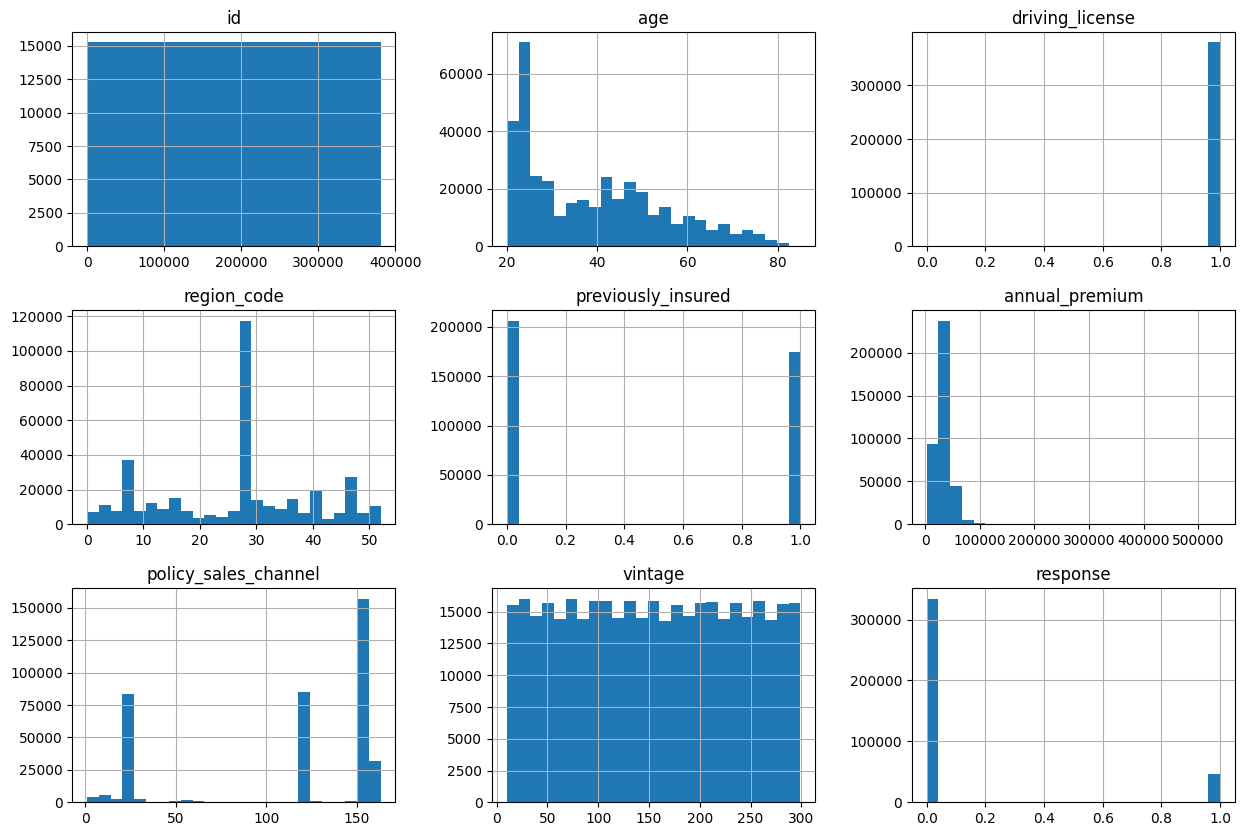

In [20]:
numerical_columns.hist(bins=25, figsize=(15, 10));

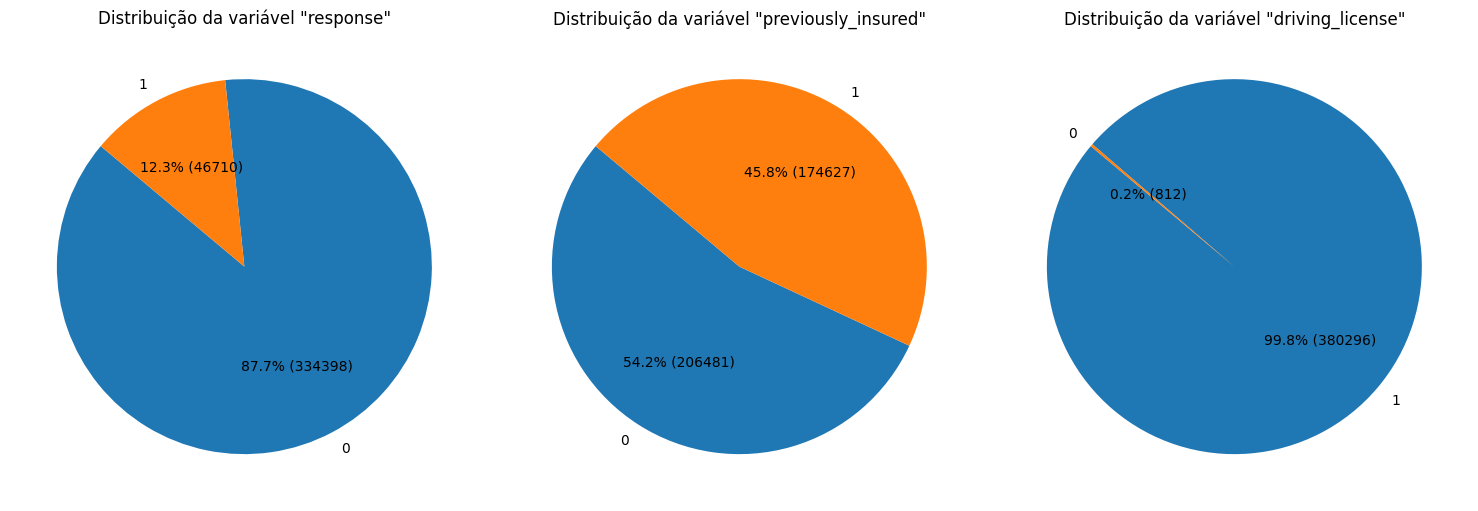

In [21]:
# Cria um grid de subplots com 1 linha e 3 colunas
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Gráfico de pizza para "gender"
value_counts = df1['response'].value_counts()
axs[0].pie(value_counts, labels=value_counts.index, autopct=lambda p: f'{p:.1f}% ({int(p * sum(value_counts) / 100)})', startangle=140)
axs[0].set_title('Distribuição da variável "response"')

# Gráfico de pizza para "vehicle_age"
value_counts = df1['previously_insured'].value_counts()
axs[1].pie(value_counts, labels=value_counts.index, autopct=lambda p: f'{p:.1f}% ({int(p * sum(value_counts) / 100)})', startangle=140)
axs[1].set_title('Distribuição da variável "previously_insured"')

# Gráfico de pizza para "vehicle_damage"
value_counts = df1['driving_license'].value_counts()
axs[2].pie(value_counts, labels=value_counts.index, autopct=lambda p: f'{p:.1f}% ({int(p * sum(value_counts) / 100)})', startangle=140)
axs[2].set_title('Distribuição da variável "driving_license"')

# Ajusta a posição dos subplots
plt.tight_layout()

# Exibe os subplots
plt.show()

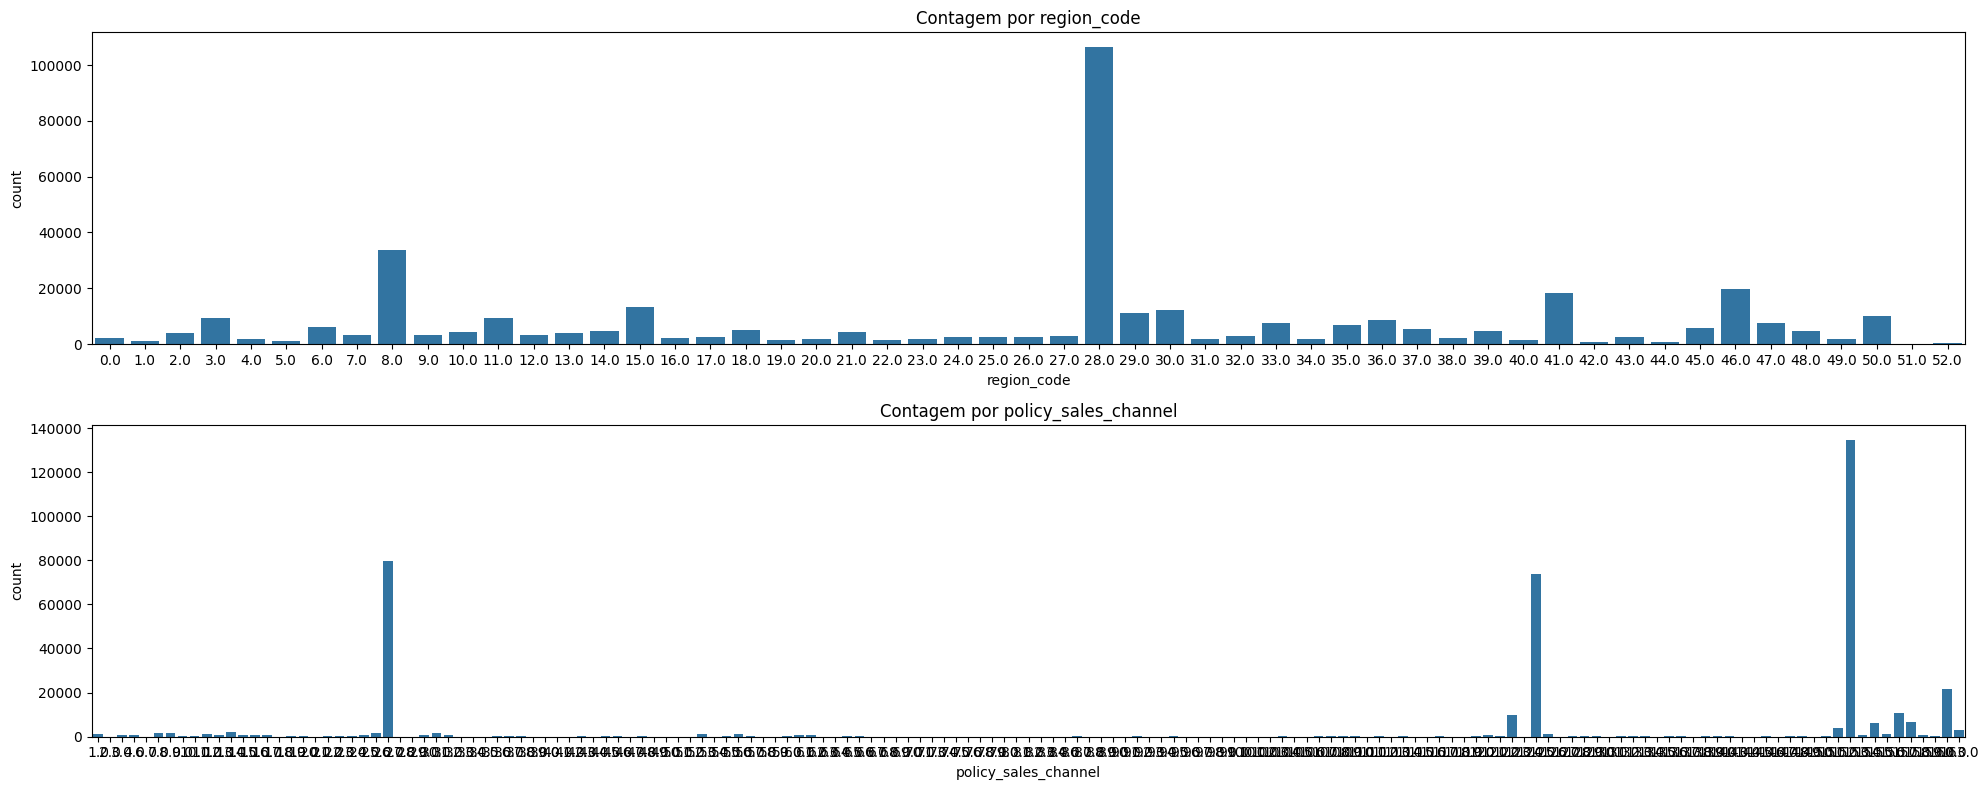

In [22]:
# Ajuste o tamanho da figura
plt.figure(figsize=(20, 8))

plt.subplot(2, 1, 1)
sns.countplot(data=df1, x='region_code')
plt.title('Contagem por region_code')

plt.subplot(2, 1, 2)
sns.countplot(data=df1, x='policy_sales_channel')
plt.title('Contagem por policy_sales_channel')

# Melhore a disposição dos subplots
plt.tight_layout()

plt.show()

### 4.5.2. Categorical Attributes:
In this section, we will analyze the categorical attributes present in dataframe df1. These attributes are non-numeric variables that represent different categories or groups. We will do an exploratory analysis of these attributes to understand their distribution and frequency.

INSIGHTS:
+ A maioria dos clientes são homens.
+ A maioria dos veículos possuem menos de 2 anos. 
+ 50,49% dos consumidores tiveram danos em seus veículos no passado. 

In [23]:
# Apply the lambda function to count the number of unique values in each categorical attribute
categorical_columns.apply(lambda x: x.unique().shape[0])

gender            2
vehicle_age       3
vehicle_damage    2
dtype: int64

In [24]:
# Describe values in each categorical attribute
categorical_columns.describe()

,gender,vehicle_age,vehicle_damage
count,381109,381109,381109
unique,2,3,2
top,Male,1-2 Year,Yes
freq,206089,200316,192413


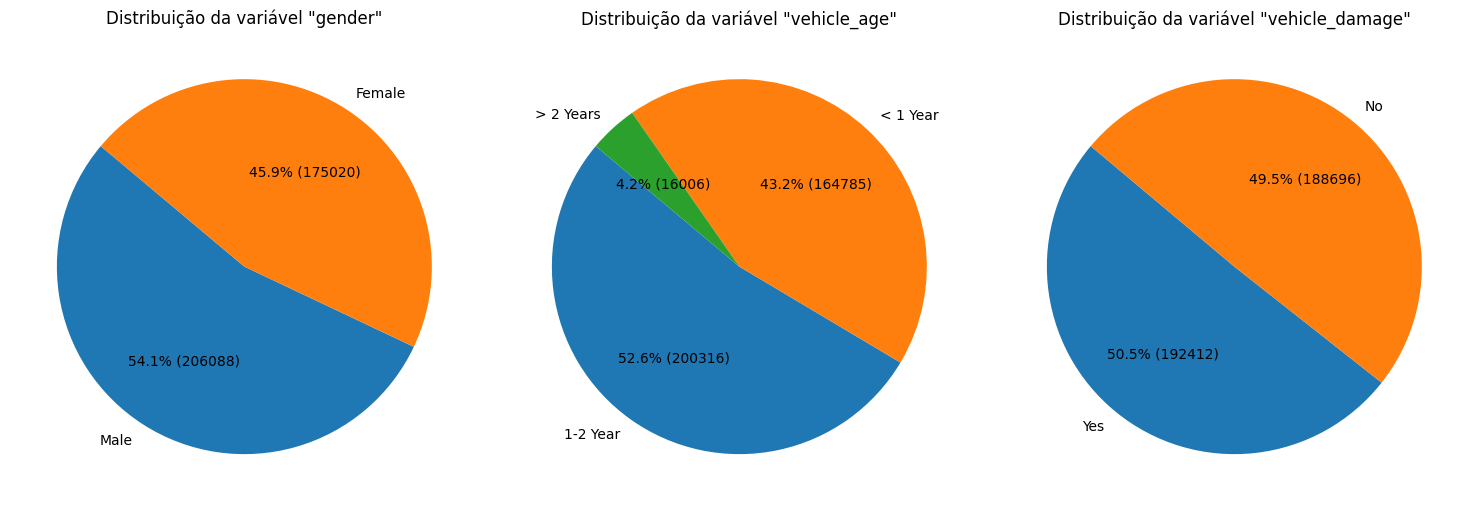

In [25]:
# Cria um grid de subplots com 1 linha e 3 colunas
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Gráfico de pizza para "gender"
value_counts = df1['gender'].value_counts()
axs[0].pie(value_counts, labels=value_counts.index, autopct=lambda p: f'{p:.1f}% ({int(p * sum(value_counts) / 100)})', startangle=140)
axs[0].set_title('Distribuição da variável "gender"')

# Gráfico de pizza para "vehicle_age"
value_counts = df1['vehicle_age'].value_counts()
axs[1].pie(value_counts, labels=value_counts.index, autopct=lambda p: f'{p:.1f}% ({int(p * sum(value_counts) / 100)})', startangle=140)
axs[1].set_title('Distribuição da variável "vehicle_age"')

# Gráfico de pizza para "vehicle_damage"
value_counts = df1['vehicle_damage'].value_counts()
axs[2].pie(value_counts, labels=value_counts.index, autopct=lambda p: f'{p:.1f}% ({int(p * sum(value_counts) / 100)})', startangle=140)
axs[2].set_title('Distribuição da variável "vehicle_damage"')

# Ajusta a posição dos subplots
plt.tight_layout()

# Exibe os subplots
plt.show()

# 5.0. - STEP FIVE - DATA CLEANING AND PRE-PREPARATION
In this step, we conducted data cleaning, preprocessing,  to enhance data quality and prepare it for the sales forecast model.

In [26]:
# GOOD PRATICE: 
# Create a copy of the DataFrame df2 it in df1.
df2 = df1.copy()

## 5.1. - Handle Missing Values (NAs): Não é preciso para este conjunto de dados
 We will apply appropriate strategies to fill in the missing data, in line with Rossmann's business model, to ensure data consistency and integrity for further analysis and modeling.

## 5.2. - Change Data Types: Não é preciso para este conjunto de dados
In this section, we will convert the data types of certain columns to more appropriate formats, optimizing memory usage, and ensuring consistency in data representation.

## 5.3. - Variable filtering: Não é preciso para este conjunto de dados
In this section, we will filter the variables to select only the relevant features for our analysis and modeling. This process aims to reduce dimensionality and focus on the most important attributes that can significantly impact sales prediction.

### 5.3.1. - Line filtering: Não é preciso para este conjunto de dados
We will remove data from stores that are closed since they would not have any sales.

### 5.3.2. - Column selection: Não é preciso para este conjunto de dados

## 5.4. - Mental Map of Hypotheses:

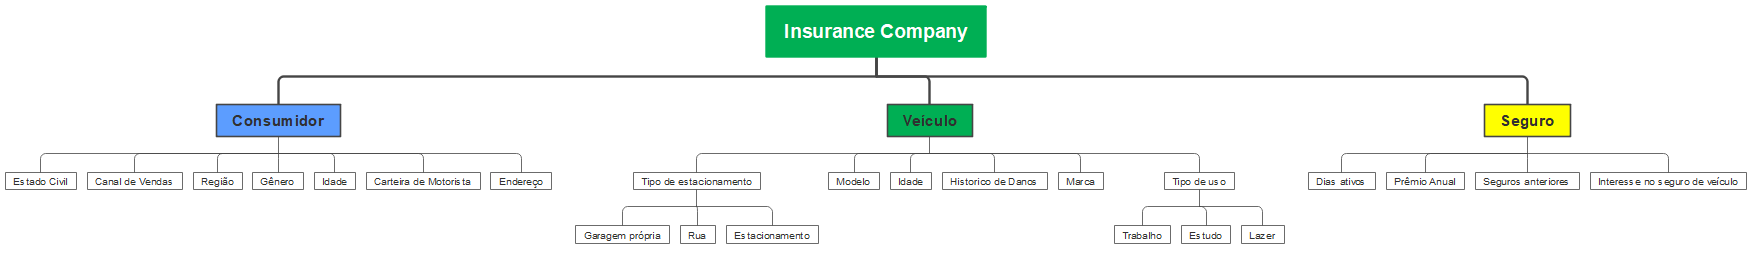

In [27]:
Image('img/MindMapHyphoteses.png')

## 5.5. - Formulation of Hypotheses:
In this section, we will formulate hypotheses that will help guide our analyzes and decision-making throughout the project. Hypotheses are assumptions that we can test using available data. They are essential to guide our exploration of the data and help us find patterns and insights relevant to the problem at hand.

### 5.5.1. - Hyphoteses related to the Customers:
1. Women buy more vehicle insurance than men. - As mulheres compram mais seguros de veículos que os homens.
2. Men tend to claim insurance more often. - Homens tendem a acionar mais vezes o seguro.
3. Customers without a driver's license are not interested in car insurance. - Clientes sem carteira de motorista não possui interesse em seguro de automóvel.
4. Customers over 30 are more interested in car insurance. - Clientes com mais de 30 anos possui mais interesse em seguross de automóvel.


### 5.5.2. - Hypotheses related to the Vehicle:
1. Customers who have a car less than 2 years old are more interested in car insurance. - Clientes que possuem carro com menos de 2 anos possui mais interesse no seguro de automóvel.

### 5.5.3. - Hypotheses related to Insurance:
1. Customers who pay a higher annual premium are more interested in vehicle insurance. - Clientes que pagam um maior prêmio anual possui mais interesse no seguro de veículos. 

# 6.0. - STEP SIX - EXPLORATORY DATA ANALYSIS (EDA)
Exploratory Data Analysis (EDA) is a critical step in any data science and predictive modeling project. In this phase, we will explore and examine the dataset in more detail to gain insights, understand patterns, identify trends and anomalies, and prepare the data for predictive modeling.

In [28]:
# Create a copy of the DataFrame df2 it in df3.
df3 = df2.copy()

## 6.1. - Practical Feature Engineering:
In this section, we will perform feature engineering on the DataFrame

In [29]:
def feature_engineering(df3):
    df3['risk_age']= df3['age'].apply(lambda x: 0 if x>25 else 1)    
    
    df3['age_insured'] = ((df3['age'] >= 32) & (df3['age'] <= 52) & (df3['previously_insured'] == 0)).astype(int)
    
    return  df3

df3 = feature_engineering(df3)

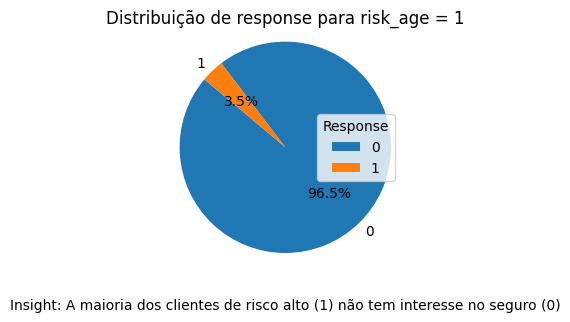

In [30]:
# Crie uma tabela de contingência entre 'risk_age' e 'response'
contingency_table = pd.crosstab(df3['risk_age'], df3['response'])

# Plote um gráfico de pizza
plt.figure(figsize=(3, 3))
plt.pie(contingency_table.loc[1], labels=contingency_table.columns, autopct='%1.1f%%', startangle=140)
plt.title('Distribuição de response para risk_age = 1')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.legend(title='Response', labels=['0', '1'])

# Adicione um insight abaixo do gráfico
plt.text(0.5, -0.2, "Insight: A maioria dos clientes de risco alto (1) não tem interesse no seguro (0)",
         ha='center', transform=plt.gca().transAxes)

plt.show()

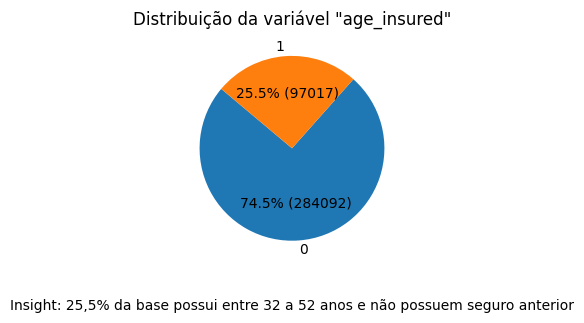

In [31]:
# Calcula a contagem dos valores
value_counts = df3['age_insured'].value_counts()

# Cria um gráfico de pizza
plt.figure(figsize=(3, 3))  # Define o tamanho do gráfico
plt.pie(value_counts, labels=value_counts.index, autopct=lambda p: f'{p:.1f}% ({int(p * sum(value_counts) / 100)})', startangle=140)

# Define o título do gráfico
plt.title('Distribuição da variável "age_insured"')

# Adicione um insight abaixo do gráfico
plt.text(0.5, -0.2, "Insight: 25,5% da base possui entre 32 a 52 anos e não possuem seguro anterior",
         ha='center', transform=plt.gca().transAxes)

# Exibe o gráfico
plt.show()


## 6.2. - Univariate Analysis:
In this section, we will perform univariate analysis on the dataset. Univariate analysis involves examining each variable individually to understand its distribution, central tendency, dispersion, and any potential outliers. This analysis helps us gain insights into the characteristics of each variable and identify any data issues that may need to be addressed.

### 6.2.1. - Reponse Variable
In this subsection, we will focus on the response variable, which is the target variable we aim to predict or explain. In our case, the response variable is the 'response' column.

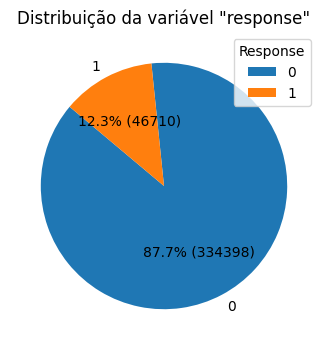

In [32]:
# Calcula a contagem dos valores
value_counts = df3  ['response'].value_counts()

# Calcula a contagem dos valores normalizados
value_percentages = df3 ['response'].value_counts(normalize=True)

# Cria um gráfico de pizza
plt.figure(figsize=(4, 4))  # Define o tamanho do gráfico
plt.pie(value_counts, labels=value_counts.index, autopct=lambda p: f'{p:.1f}% ({int(p * sum(value_counts) / 100)})', startangle=140)
plt.legend(title='Response', labels=['0', '1'])

# Define o título do gráfico
plt.title('Distribuição da variável "response"')

# Exibe o gráfico
plt.show()

### 6.2.2. - Numerical Variable:
In this section, we will perform a univariate analysis of numeric variables. Numerical variables are those that represent quantitative values.

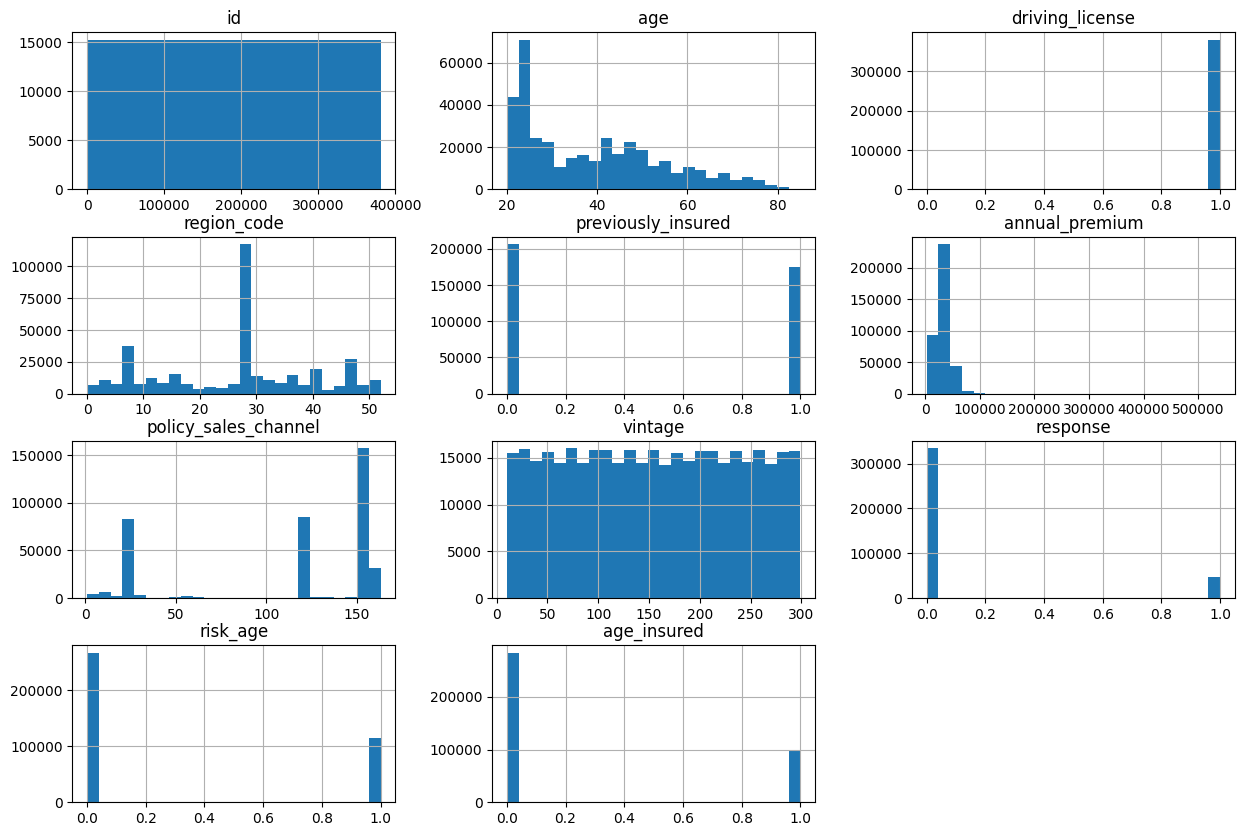

In [33]:
# Incluindo a coluna risk_age nos atributos categóricos
numerical_columns = df3.select_dtypes(include=['int64', 'int32','float64'])

# Plot histograms for all numerical columns
numerical_columns.hist(bins=25, figsize=(15, 10));

### 6.2.3. - Categorical Variable:
In this section, we will explore the categorical variables in our dataset. Categorical variables are non-numeric and represent different categories or groups.

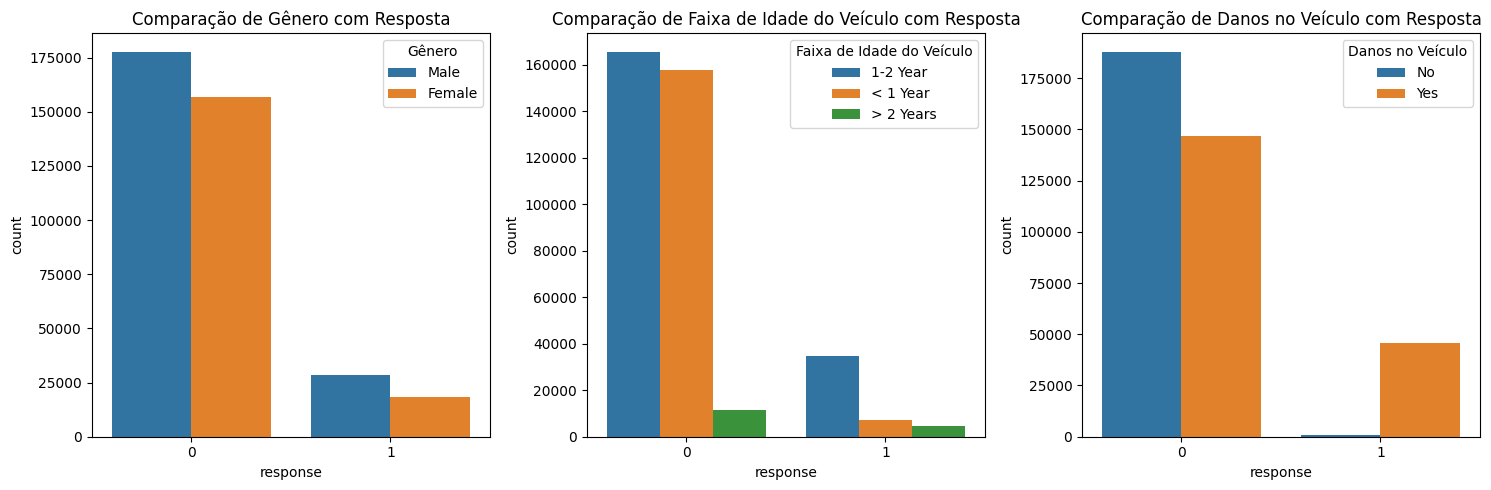

In [34]:
# Define o número de linhas e colunas para o grid de subplots
num_rows = 1  # Uma linha
num_cols = 3  # Três colunas (um para cada gráfico)

# Cria um grid de subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5))

# Plota o primeiro gráfico (Comparação de Gênero com Resposta)
sns.countplot(data=df3, x='response', hue='gender', ax=axes[0])
axes[0].set_title('Comparação de Gênero com Resposta')
axes[0].legend(title='Gênero')

# Plota o segundo gráfico (Comparação de Faixa de Idade do Veículo com Resposta)
sns.countplot(data=df3, x='response', hue='vehicle_age', ax=axes[1])
axes[1].set_title('Comparação de Faixa de Idade do Veículo com Resposta')
axes[1].legend(title='Faixa de Idade do Veículo')

# Plota o terceiro gráfico (Comparação de Danos no Veículo com Resposta)
sns.countplot(data=df3, x='response', hue='vehicle_damage', ax=axes[2])
axes[2].set_title('Comparação de Danos no Veículo com Resposta')
axes[2].legend(title='Danos no Veículo')

# Ajusta a posição dos subplots
plt.tight_layout()

# Exibe os gráficos
plt.show()

Tabela de Contingência (gender vs vehicle_age):
vehicle_age  1-2 Year  < 1 Year  > 2 Years
gender                                    
Female          77992     91321       5707
Male           122324     73465      10300

Tabela de Contingência (gender vs vehicle_damage):
vehicle_damage     No     Yes
gender                       
Female          95355   79665
Male            93341  112748
Tabela de Contingência (vehicle_damage vs vehicle_age):
vehicle_age     1-2 Year  < 1 Year  > 2 Years
vehicle_damage                               
No                 72091    116590         15
Yes               128225     48196      15992


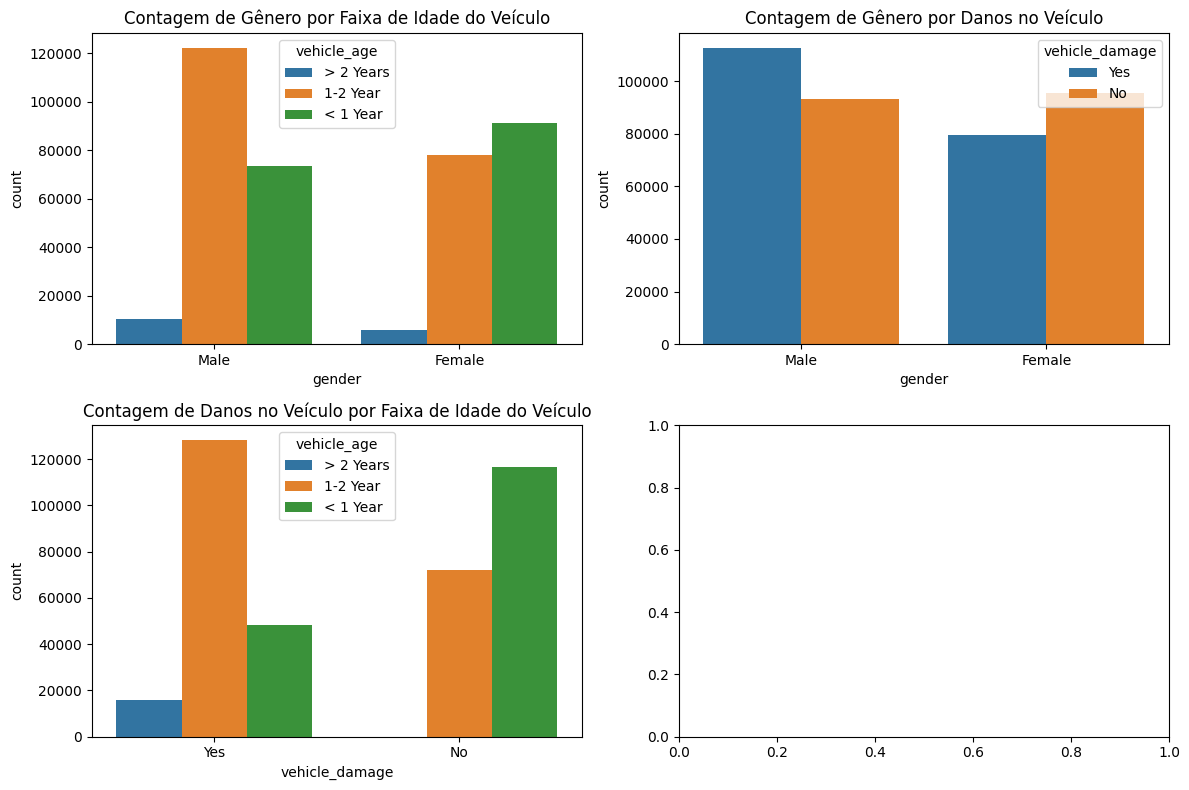

In [35]:
# Define o número de linhas e colunas para o grid de subplots
num_rows = 2  # Três linhas (uma para cada comparação)
num_cols = 2  # Duas colunas (uma para a tabela e outra para o gráfico)

# Cria um grid de subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

# Tabela de contingência para comparar gender e vehicle_age
contingency_table = pd.crosstab(df3['gender'], df3['vehicle_age'])
print("Tabela de Contingência (gender vs vehicle_age):")
print(contingency_table)

# Gráfico de barras para gender vs vehicle_age
sns.countplot(data=df3, x='gender', hue='vehicle_age', ax=axes[0, 0])
axes[0, 0].set_title('Contagem de Gênero por Faixa de Idade do Veículo')

# Tabela de contingência para comparar gender e vehicle_damage
contingency_table = pd.crosstab(df3['gender'], df3['vehicle_damage'])
print("\nTabela de Contingência (gender vs vehicle_damage):")
print(contingency_table)

# Gráfico de barras para gender vs vehicle_damage
sns.countplot(data=df3, x='gender', hue='vehicle_damage', ax=axes[0, 1])
axes[0, 1].set_title('Contagem de Gênero por Danos no Veículo')

# Tabela de contingência para comparar vehicle_damage e vehicle_age
contingency_table = pd.crosstab(df3['vehicle_damage'], df3['vehicle_age'])
print("Tabela de Contingência (vehicle_damage vs vehicle_age):")
print(contingency_table)

# Gráfico de barras para vehicle_damage vs vehicle_age
sns.countplot(data=df3, x='vehicle_damage', hue='vehicle_age', ax=axes[1, 0])
axes[1, 0].set_title('Contagem de Danos no Veículo por Faixa de Idade do Veículo')

# Ajusta a posição dos subplots
plt.tight_layout()

# Exibe os subplots
plt.show()

## 6.3. - Bivariate Analysis:
In this section, we will perform a bivariate analysis, exploring the relationship between two variables. Let's investigate how numerical and categorical variables behave together and how they can influence response.

### 6.3.1. Age:

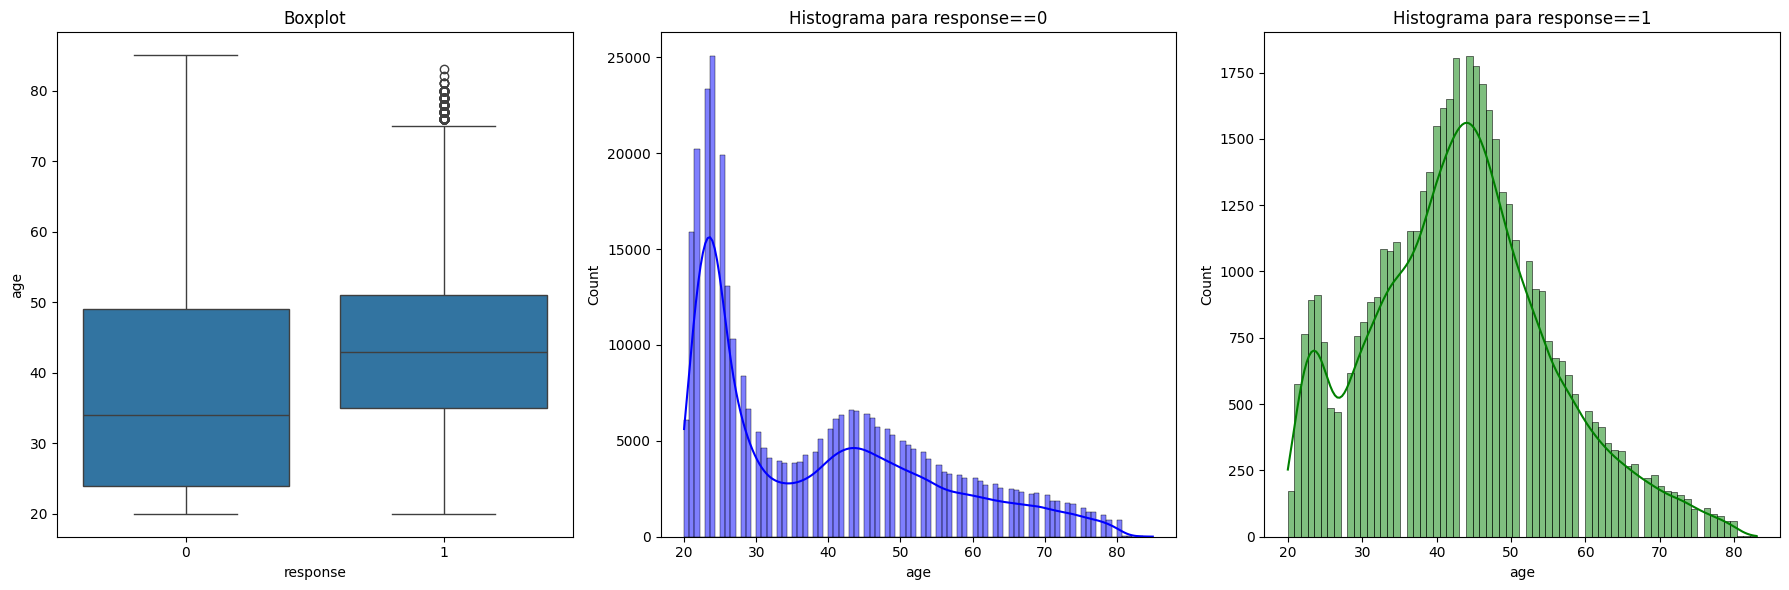

In [36]:
# Crie uma grade de subplots com 1 linha e 3 colunas
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Primeiro gráfico: boxplot
sns.boxplot(x='response', y='age', data=df3, ax=axes[0])
axes[0].set_title('Boxplot')

# Segundo gráfico: histograma para response==0
aux00 = df3.loc[df3['response'] == 0, 'age']
sns.histplot(aux00, ax=axes[1], kde=True, color='blue')
axes[1].set_title('Histograma para response==0')

# Terceiro gráfico: histograma para response==1
aux01 = df3.loc[df3['response'] == 1, 'age']
sns.histplot(aux01, ax=axes[2], kde=True, color='green')
axes[2].set_title('Histograma para response==1')

# Ajuste o layout dos gráficos
plt.tight_layout()

# Exiba os gráficos
plt.show()

### 6.3.2. Annual Premium:

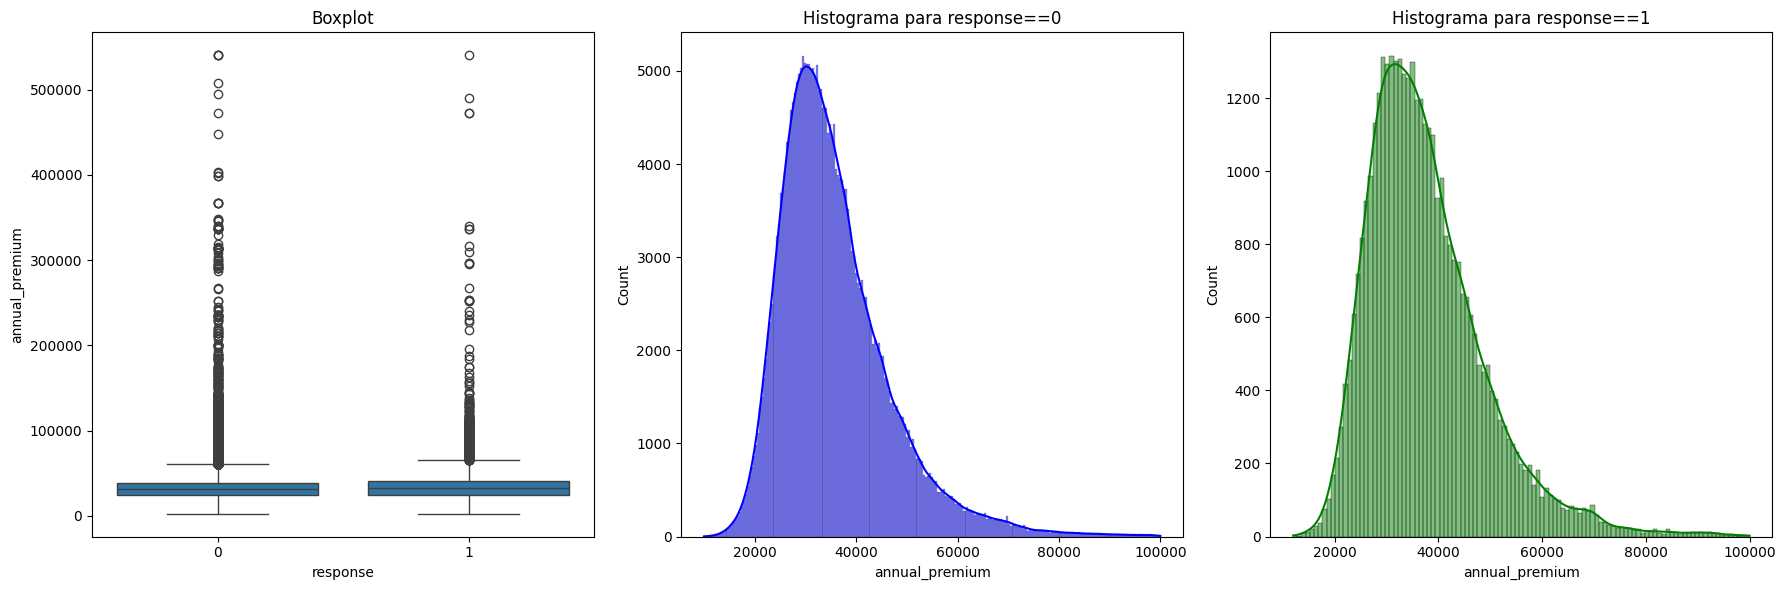

In [37]:
# Crie uma grade de subplots com 1 linha e 3 colunas
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Primeiro gráfico: boxplot
sns.boxplot( x='response', y='annual_premium', data=df3, ax=axes[0])
axes[0].set_title('Boxplot')

# Filtrando os dados da coluna Annual Premium para uma melhor visualização
df3 = df3[(df3['annual_premium'] > 10000) & (df3['annual_premium'] < 100000)]

# Segundo gráfico: histograma para response==0
aux00 = df3.loc[df3['response'] == 0, 'annual_premium']
sns.histplot(aux00, ax=axes[1], kde=True, color='blue')
axes[1].set_title('Histograma para response==0')

# Terceiro gráfico: histograma para response==1
aux01 = df3.loc[df3['response'] == 1, 'annual_premium']
sns.histplot(aux01, ax=axes[2], kde=True, color='green')
axes[2].set_title('Histograma para response==1')

# Ajuste o layout dos gráficos
plt.tight_layout()

# Exiba os gráficos
plt.show()

### 6.3.3. Driving License.

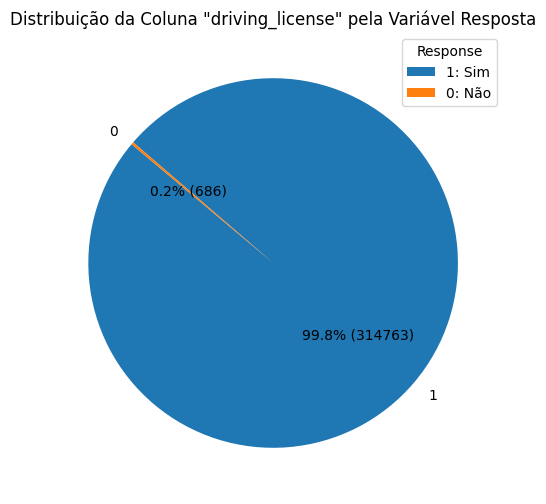

In [38]:
# Calcula a contagem dos valores
value_counts = df3['driving_license'].value_counts()

# Plote um gráfico de pizza
plt.figure(figsize=(6, 6))  # Define o tamanho do gráfico
plt.pie(value_counts, labels=value_counts.index, autopct=lambda p: f'{p:.1f}% ({int(p * sum(value_counts) / 100)})', startangle=140)

# Adicione uma legenda à variável resposta
plt.legend(title='Response', labels=['1: Sim', '0: Não'], loc='best')

# Define o título do gráfico
plt.title('Distribuição da Coluna "driving_license" pela Variável Resposta')

# Exibe o gráfico
plt.show()

### 6.3.4. Region Code.

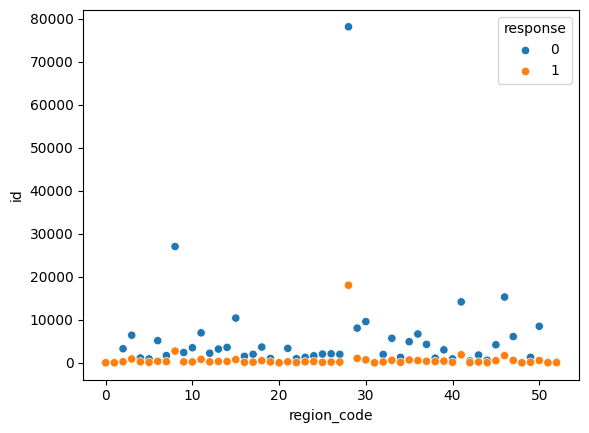

In [39]:
aux0 = df3[['id', 'region_code', 'response']].groupby( ['region_code', 'response'] ).count().reset_index()
#aux0 = aux0[(aux0['id'] > 1000) & (aux0['id'] < 20000)]

sns.scatterplot( x='region_code', y='id', hue='response', data=aux0 );

### 6.3.5. Previously Insurance.

INSIGHT:
+ Quem já tem seguro de veículo, não possui interesse no novo.
+ Dos que não possuem seguro de veículo ainda, 22,5% diz ter interesse.

- A diferença nas probabilidades entre esses dois grupos é significativa, indicando que a variável "previously_insured" pode ser um preditor importante para a variável "response". Clientes não segurados têm uma probabilidade muito maior de se interessar por um seguro do que aqueles que já foram segurados.

response,0,1
previously_insured,,
0,0.7694,0.2306
1,0.9992,0.0008


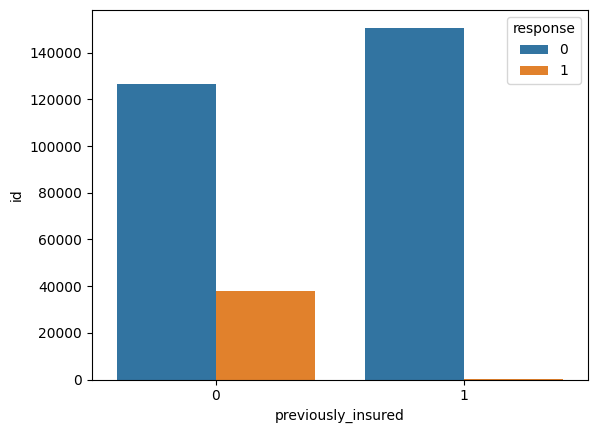

In [40]:
aux0 = df3[['id', 'previously_insured', 'response']].groupby( ['previously_insured', 'response'] ).count().reset_index()
#aux0 = aux0[(aux0['id'] > 1000) & (aux0['id'] < 20000)]

sns.barplot( x='previously_insured', y='id', hue='response', data=aux0 );

pd.crosstab(df3['previously_insured'], df3['response'] ).apply( lambda x: x / x.sum(), axis=1 )

### 6.3.6. Vehicle Age.

In [41]:
df3[['id','vehicle_age', 'response']].groupby( ['vehicle_age', 'response'] ).count().reset_index()

,vehicle_age,response,id
0,1-2 Year,0,130381
1,1-2 Year,1,28017
2,< 1 Year,0,137861
3,< 1 Year,1,5994
4,> 2 Years,0,9126
5,> 2 Years,1,4070


### 6.3.7. Vehicle Damage.

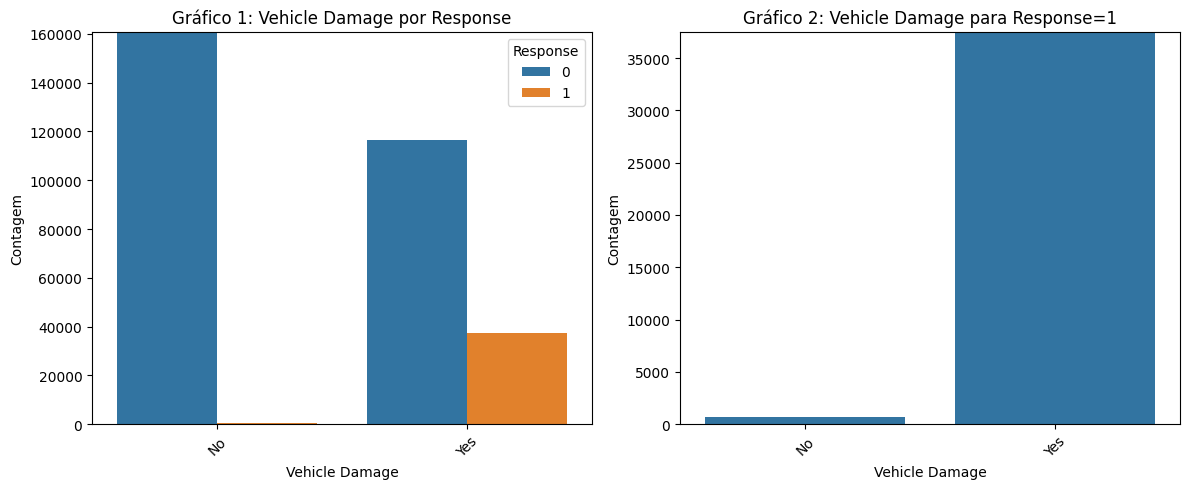

In [42]:
# Crie um DataFrame auxiliar para o primeiro gráfico de barras
aux1 = df3[['vehicle_damage', 'response']].groupby(['vehicle_damage', 'response']).size().reset_index().rename(columns={0: 'qtd'})

# Crie um DataFrame auxiliar para o segundo gráfico de barras
aux2 = df3[df3['response'] == 1]
aux2 = aux2[['vehicle_damage', 'response']].groupby(['vehicle_damage', 'response']).size().reset_index().rename(columns={0: 'qtd'})

# Crie uma figura com dois subplots lado a lado
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Primeiro subplot (gráfico de barras)
sns.barplot(data=aux1, x='vehicle_damage', y='qtd', hue='response', ax=axs[0])
total1 = sum(aux1['qtd'])
axs[0].set_title('Gráfico 1: Vehicle Damage por Response')
axs[0].set_xlabel('Vehicle Damage')
axs[0].set_ylabel('Contagem')
axs[0].legend(title='Response')
axs[0].set_ylim(0, max(aux1['qtd']) + 100)  # Defina limites y para melhor visualização
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45)

# Segundo subplot (gráfico de barras)
sns.barplot(data=aux2, x='vehicle_damage', y='qtd', ax=axs[1])
total2 = sum(aux2['qtd'])
axs[1].set_title('Gráfico 2: Vehicle Damage para Response=1')
axs[1].set_xlabel('Vehicle Damage')
axs[1].set_ylabel('Contagem')
axs[1].set_ylim(0, max(aux2['qtd']) + 100)  # Defina limites y para melhor visualização
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45)

# Exiba os gráficos
plt.tight_layout()
plt.show()

### 6.3.8. Policy Sales Chamnel.

,policy_sales_channel,response,total_responses
0,1.0000,0,10
1,2.0000,0,1
2,3.0000,136,434
3,4.0000,90,442
4,6.0000,0,2


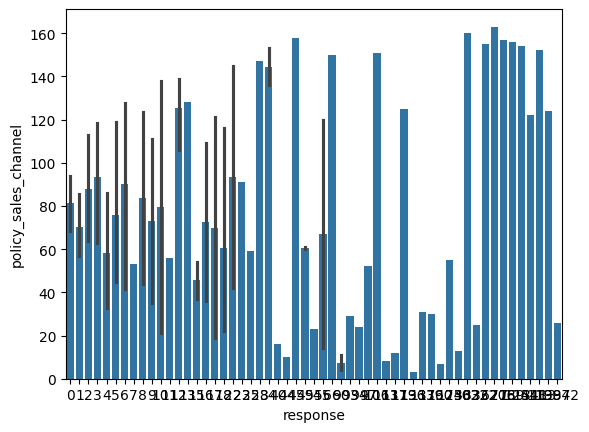

In [43]:
aux = df3[['policy_sales_channel', 'response']].groupby( 'policy_sales_channel' ).sum().reset_index()
sns.barplot( x='response', y='policy_sales_channel', data=aux );

aux01 = df3[['policy_sales_channel', 'response']].groupby( 'policy_sales_channel' ).sum().reset_index()
aux02 = df3[['id', 'policy_sales_channel']].groupby( 'policy_sales_channel' ).size().reset_index().rename( columns={0:'total_responses'})

aux = pd.merge( aux01, aux02, how='inner', on='policy_sales_channel' )
aux.head()

### 6.3.9. Vintage.

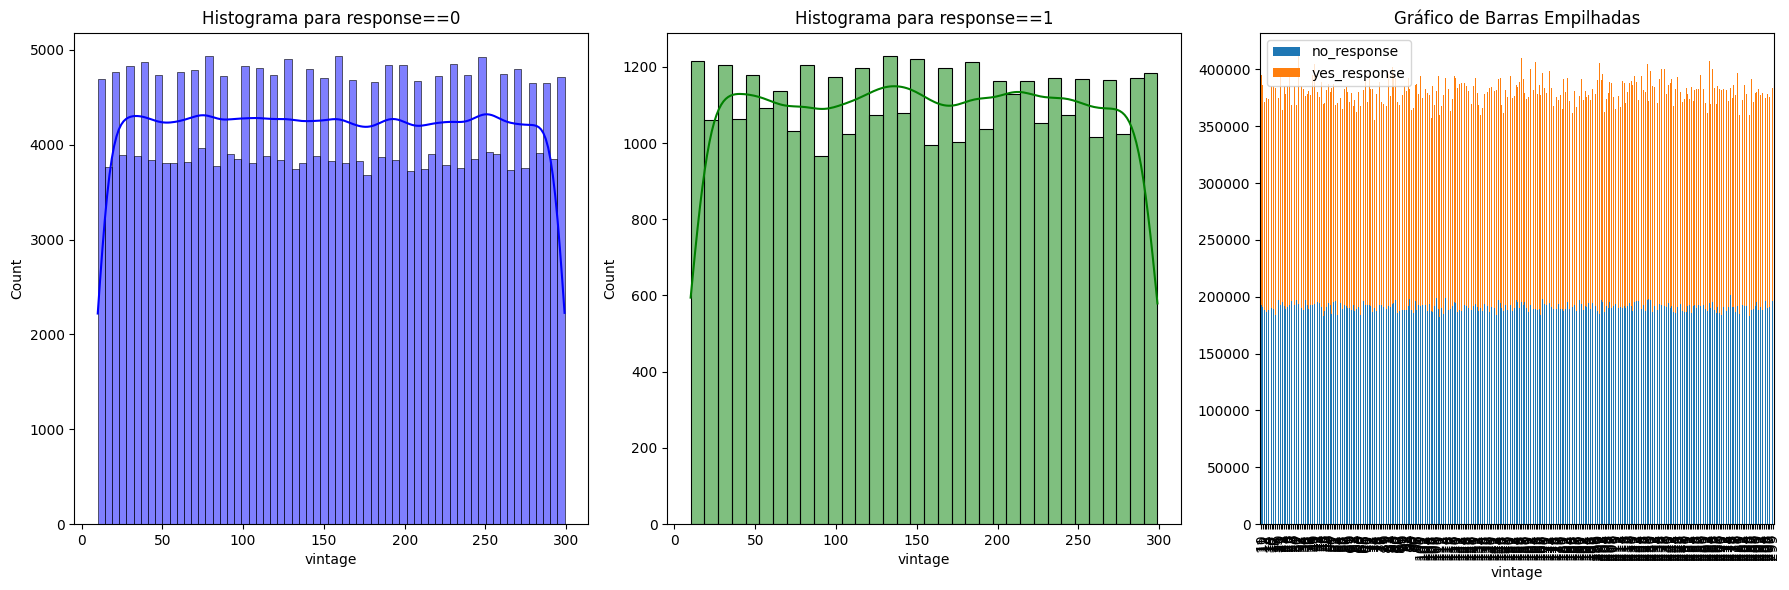

In [44]:
# Crie uma grade de subplots com 1 linha e 3 colunas
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Primeiro gráfico: histograma para response==0
aux0 = df3.loc[df3['response'] == 0, 'vintage']
sns.histplot(aux0, ax=axes[0], kde=True, color='blue')
axes[0].set_title('Histograma para response==0')

# Segundo gráfico: histograma para response==1
aux1 = df3.loc[df3['response'] == 1, 'vintage']
sns.histplot(aux1, ax=axes[1], kde=True, color='green')
axes[1].set_title('Histograma para response==1')

# Terceiro gráfico: gráfico de barras empilhadas
df = pd.pivot_table(index='vintage', columns='response', values='id', data=df3).reset_index()
df.columns = ['vintage', 'no_response', 'yes_response']
df.plot(x='vintage', kind='bar', stacked=True, ax=axes[2])
axes[2].set_title('Gráfico de Barras Empilhadas')

# Ajuste o layout dos gráficos
plt.tight_layout()

# Exiba os gráficos
plt.show()

### 6.3.10. Risk Age.

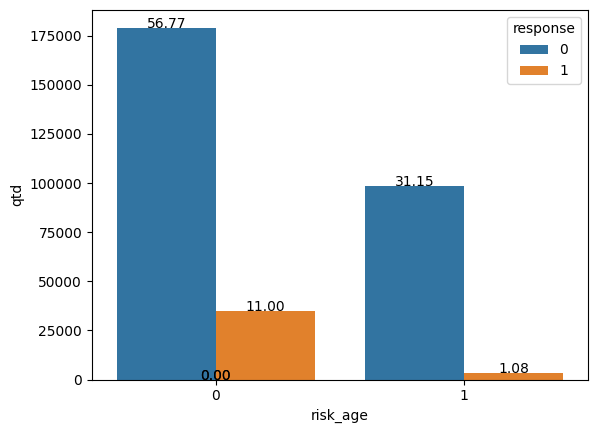

In [45]:
aux = df3[['risk_age','response']].groupby(['risk_age','response']).size().reset_index().rename(columns={0:'qtd'})
ax = sns.barplot(x='risk_age',y='qtd',data=aux,hue='response');
total = sum(aux['qtd'])
graphic_percentage(ax,total)

### 6.3.11. Age Insured.
INSIGHT:
+ Dos que responderam que queria um seguro de automovél, 61,93% possuem idade entre 32 a 52 anos e não possuem seguro de veículo.
+ Dos que possuem idade entre 32 a 52 anos e não possuem seguro de veículo, 61,1% são homens.

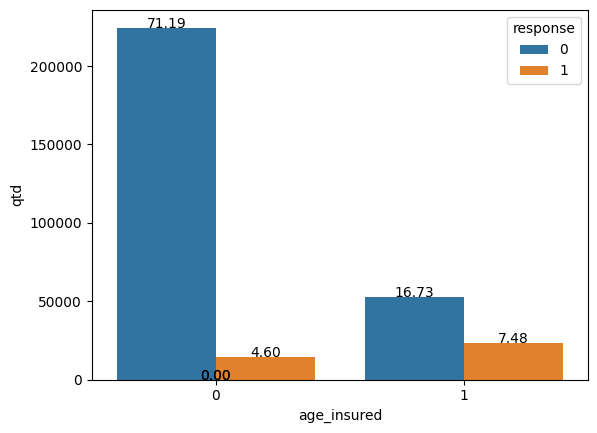

Correlação entre 'age_insured' e 'response': 0.32623986194710874


In [46]:
aux = df3[['age_insured','response']].groupby(['age_insured','response']).size().reset_index().rename(columns={0:'qtd'})
ax = sns.barplot(x='age_insured',y='qtd',data=aux,hue='response');
total = sum(aux['qtd'])
graphic_percentage(ax,total)

correlation = df3['age_insured'].corr(df3['response'])
print(f"Correlação entre 'age_insured' e 'response': {correlation}")

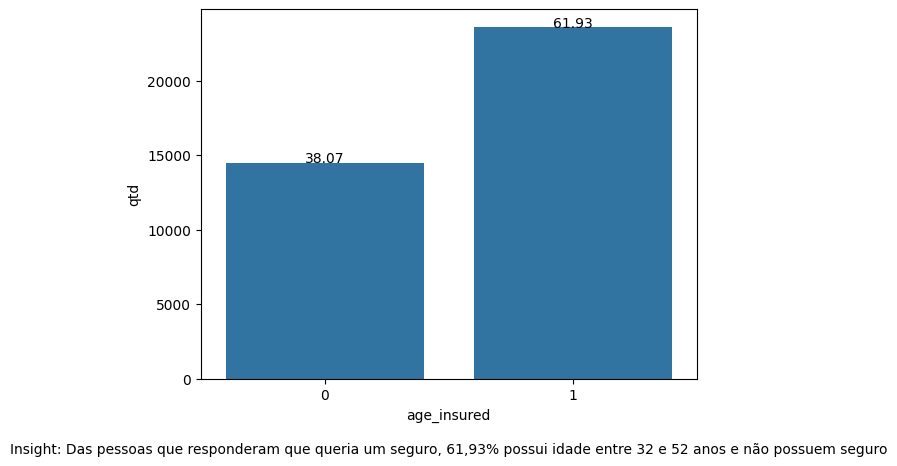

In [47]:
aux=aux[aux['response']==1]
ax = sns.barplot(data=aux,x='age_insured',y='qtd');
total=sum(aux['qtd'])

# Adicione um insight abaixo do gráfico
plt.text(0.5, -0.2, "Insight: Das pessoas que responderam que queria um seguro, 61,93% possui idade entre 32 e 52 anos e não possuem seguro",
         ha='center', transform=plt.gca().transAxes)

graphic_percentage(ax,total)

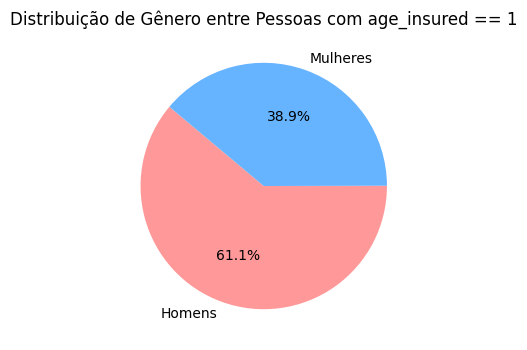

In [48]:
# Filtra o DataFrame para pessoas com age_insured == 1
filtered_df = df3[df3['age_insured'] == 1]

# Calcula o número de homens com age_insured == 1
homens_age_insured = len(filtered_df[filtered_df['gender'] == 'Male'])

# Calcula o número de mulheres com age_insured == 1
mulheres_age_insured = len(filtered_df[filtered_df['gender'] == 'Female'])

# Define os rótulos e os valores para o gráfico de pizza
labels = ['Homens', 'Mulheres']
sizes = [homens_age_insured, mulheres_age_insured]
colors = ['#ff9999', '#66b3ff']  # Cores para os setores do gráfico

# Cria o gráfico de pizza
plt.figure(figsize=(4, 4))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=140)

# Define o título do gráfico
plt.title('Distribuição de Gênero entre Pessoas com age_insured == 1')

# Exibe o gráfico
plt.show()

## 6.3.12. Hyphoteses Validation

### H1) Women buy more vehicles insurance than men
False - Men (61,31%) have more interest in vehicles insurance than women (38,69%)

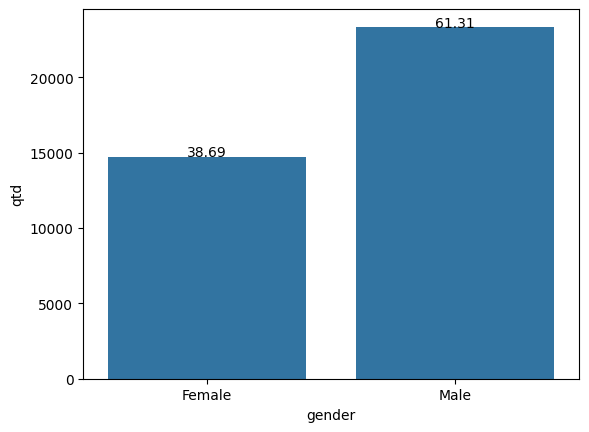

In [49]:
aux = df3[df3['response']==1]
aux = aux[['gender']].groupby('gender').size().reset_index().rename(columns={0:'qtd'})
ax = sns.barplot(data=aux,x='gender',y='qtd')
total = sum(aux['qtd'])
graphic_percentage(ax,total)

### H2) Men tend to claim insurance more often
True - Men (58,39%) have more damage vehicle than women (41,61%)

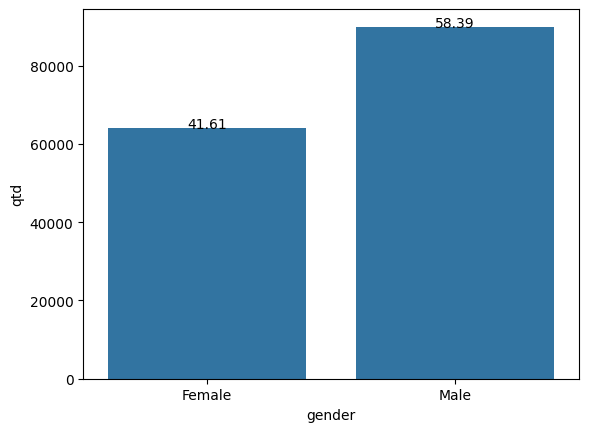

In [50]:
aux = df3[df3['vehicle_damage']=='Yes']
aux = aux[['gender']].groupby('gender').size().reset_index().rename(columns={0:'qtd'})
ax = sns.barplot(data=aux,x='gender',y='qtd')
total = sum(aux['qtd'])
graphic_percentage(ax,total)

### H3) Customers without a driver's license are not interested in car insurance
As the proportion of customers who do not have a wallet is very small in the dataset, customers who do not have a wallet will be analyzed individually.

Paradox - As the base of those who do not have a license is small, and ~5% of them say they are interested in insurance. It could be an important group of consumers.

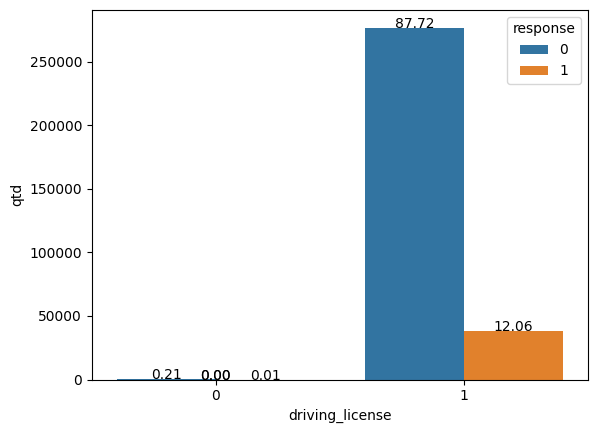

In [51]:
aux=df3[['driving_license','response']].groupby(['driving_license','response']).size().reset_index().rename(columns={0:'qtd'})
ax=sns.barplot(data=aux,x='driving_license',y='qtd',hue='response');
total=sum(aux['qtd'])
graphic_percentage(ax,total)

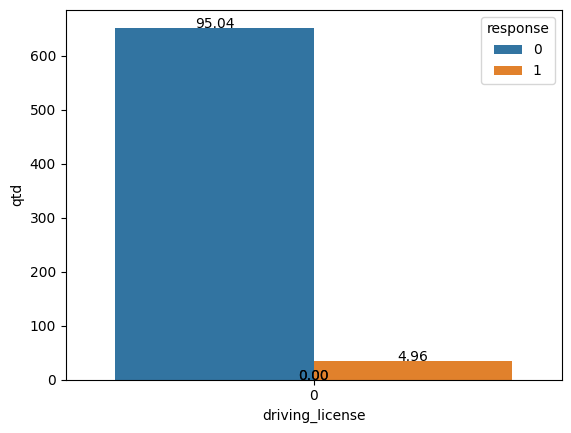

In [52]:
aux=aux[aux['driving_license']==0]
ax=sns.barplot(data=aux,x='driving_license',y='qtd',hue='response');
total=sum(aux['qtd'])
graphic_percentage(ax,total)

### H4) Customers over 30 are more interested in car insurance.
True - Almost 85% of customer interesting on vehicle insurance has more then 30 years old

INSIGHT: 
+ There is a group of 22 to 25 year olds who also have a reasonable interest. Despite being in the risk group.
+ The most interested parties are between 33 and 54 years old.

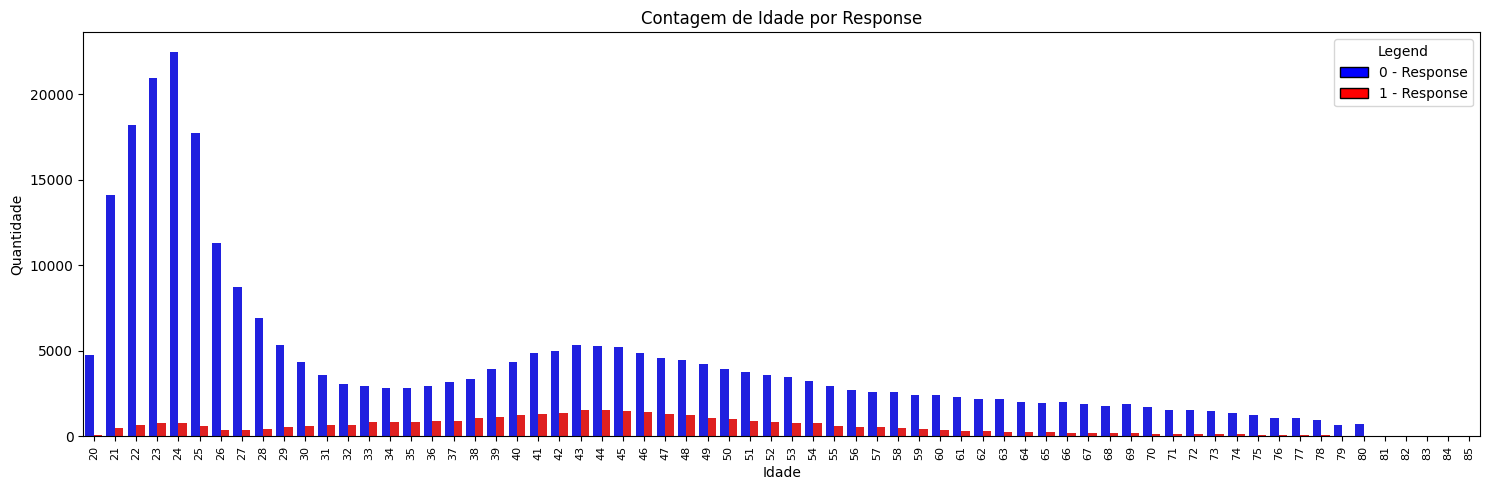

In [53]:
# Seu DataFrame auxiliar com a contagem
aux = df3[['age', 'response']].groupby(['age', 'response']).size().reset_index().rename(columns={0: 'qtd'})

# Crie uma paleta de cores com as cores desejadas para cada valor de 'response'
palette = {0: 'blue', 1: 'red'}

plt.figure(figsize=(15, 5))
ax = sns.barplot(data=aux, x='age', y='qtd', hue='response', palette=palette)

ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=8)
plt.title('Contagem de Idade por Response')
plt.xlabel('Idade')
plt.ylabel('Quantidade')

# Crie manualmente as legendas coloridas
legend_labels = ['0 - Response', '1 - Response']
colors = ['blue', 'red']
handles = [plt.Rectangle((0, 0), 1, 1, color=colors[i], ec="k") for i in range(len(legend_labels))]
plt.legend(handles, legend_labels, title='Legend', loc='upper right')

plt.tight_layout()
plt.show()

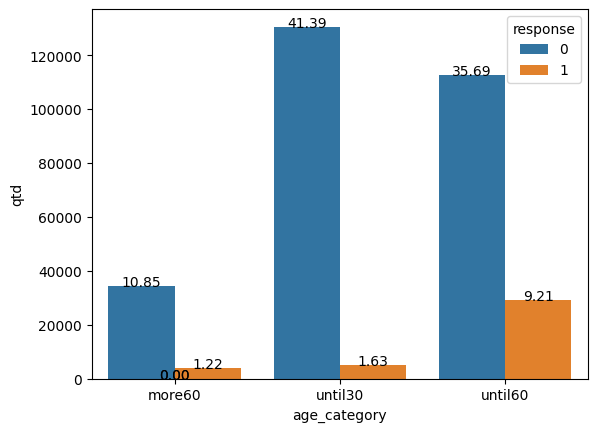

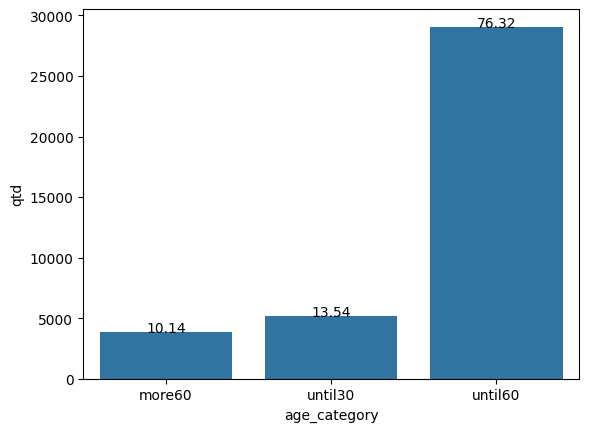

In [54]:
aux = df3.copy()
aux['age_category'] = df3['age'].apply(lambda x: 'until30' if x<30 else 'until60' if x>=30 and x<60 else 'more60')
aux = aux[['age_category','response']].groupby(['age_category','response']).size().reset_index().rename(columns={0:'qtd'})
ax = sns.barplot(data=aux,x='age_category',y='qtd',hue='response');
total = sum(aux['qtd'])

graphic_percentage(ax,total)


aux=aux[aux['response']==1]
ax=sns.barplot(data=aux,x='age_category',y='qtd');
total=sum(aux['qtd'])

graphic_percentage(ax,total)

### H5) Customers who have a car less than 2 years old are more interested in car insurance.
True - Almost 89% of customer interesting on vehicle insurance has car age less then 2 years

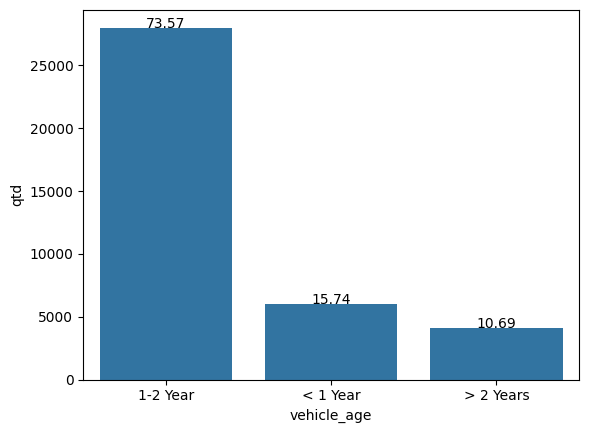

In [55]:
aux = df3[df3['response']==1]
aux = aux[['vehicle_age']].groupby('vehicle_age').size().reset_index().rename(columns={0:'qtd'})
ax = sns.barplot(data=aux,x='vehicle_age',y='qtd');
total = sum(aux['qtd'])

graphic_percentage(ax,total)

### H6) Customer that paid between 25000 a 40000 on Annual Premium have more interest in vehicles insurance
True - Customer that paid between 25000 a 40000 on Annual Premium correspond a 53,40% of customer interesting in vehicles insurance

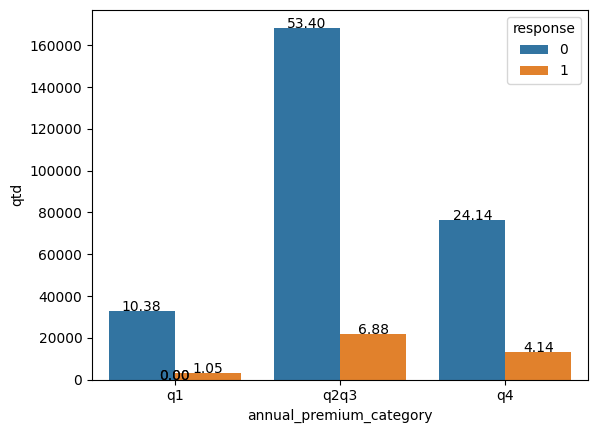

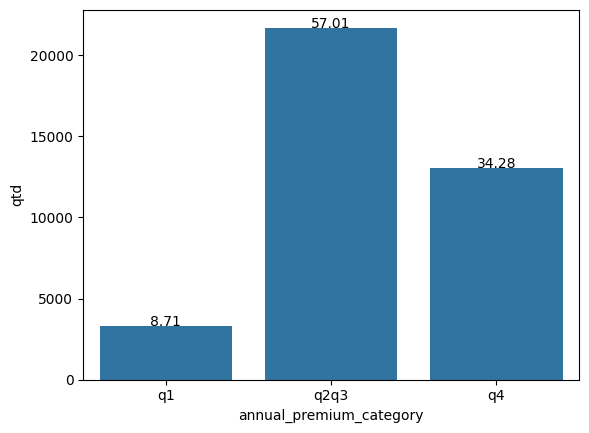

In [56]:
aux = df3.copy()
aux['annual_premium_category'] = aux['annual_premium'].apply(lambda x: 'q1' if x<25000 else 'q4' if x>40000 else 'q2q3')
aux=aux[['annual_premium_category','response']].groupby(['annual_premium_category','response']).size().reset_index().rename(columns={0:'qtd'})
ax=sns.barplot(data=aux,x='annual_premium_category',y='qtd',hue='response');
total=sum(aux['qtd'])
graphic_percentage(ax,total)

aux=aux[aux['response']==1]
ax=sns.barplot(data=aux,x='annual_premium_category',y='qtd');
total=sum(aux['qtd'])
graphic_percentage(ax,total)

### 6.3.12. Summary of hypotheses:

In [57]:
# Data for the table
tab = [['Hypothesis', 'Conclusion'],
       ['H1', 'False'],
       ['H2', 'True'],
       ['H3', '-'],
       ['H4', 'True'],
       ['H5', 'True'],
       ['H6', 'True']]

# Print the table using the tabulate function from the tabulate library
print(tabulate(tab, headers='firstrow'))

Hypothesis    Conclusion
------------  ------------
H1            False
H2            True
H3            -
H4            True
H5            True
H6            True


## 6.4. - Multivariate analysis:

### 6.4.1. - Numerical Attributes:

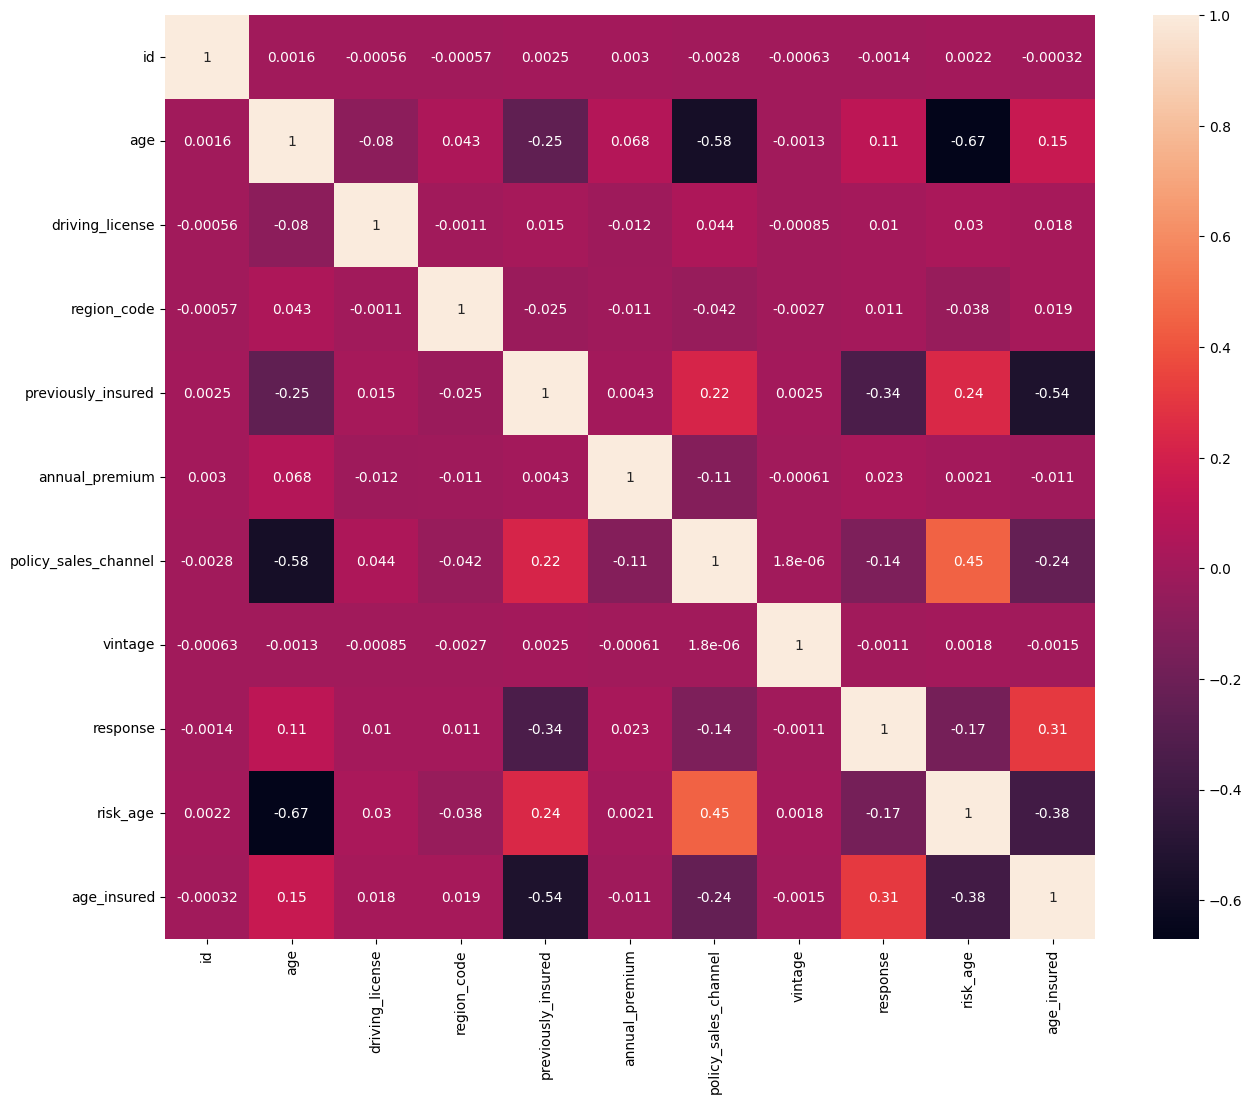

In [58]:
# Calculate the correlation matrix using Pearson correlation method for numeric attributes.
correlation = numerical_columns.corr(method='pearson')

# Set the figure size
plt.figure(figsize=(15, 12))

# Plot the heatmap
sns.heatmap(correlation, annot=True)

# Display the heatmap
plt.show()

### 6.4.2. - Categorical Attributes:

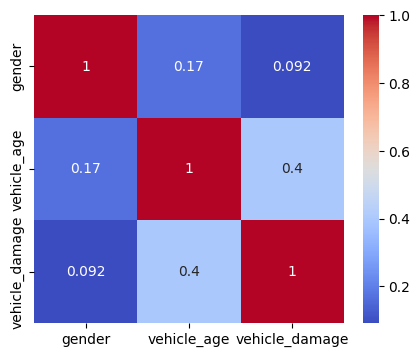

In [59]:
# Calcule as correlações de Cramer's V para as variáveis categóricas
matriz_corr_cramer_v = corr_cramer_v(categorical_columns)

# Crie um DataFrame a partir da matriz de correlação
df_corr_cramer_v = pd.DataFrame(matriz_corr_cramer_v, index=categorical_columns.columns, columns=categorical_columns.columns)

# Defina o tamanho da figura
plt.figure(figsize=(5, 4))

# Plote o mapa de calor
sns.heatmap(df_corr_cramer_v, annot=True, cmap='coolwarm')

# Exiba o mapa de calor
plt.show()

# 7.0. - STEP SEVEN - DATA MODELING
In this step, we will focus on preparing the data for training machine learning models. Data modeling is a crucial step in the model building process, as it ensures that the data is in a suitable format and contains the relevant information for learning the algorithm.

In [60]:
# Create a copy of the DataFrame df3 it in df4.
df4 = df3.copy()

In [61]:
# Spliting test dataset before 
x=df4.drop(columns='response')
y=df4['response']

# Redefina o índice do DataFrame x e y
x.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)

split = ms.StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(x,y):
    x_train,x_test = x.loc[train_index],x.loc[test_index]
    y_train,y_test = y.loc[train_index],y.loc[test_index]
    
for train_index, test_index in split.split(x_train,y_train):
    x_train,x_val = x_train.iloc[train_index],x.loc[test_index]
    y_train,y_val = y_train.iloc[train_index],y.loc[test_index]

df5=pd.concat([x_train,y_train],axis=1)

## 7.2. - Standardization

In [62]:
ss = pp.StandardScaler()

# anual premium - StandarScaler
df5['annual_premium'] = ss.fit_transform( df5[['annual_premium']].values )
pickle.dump( ss, open( '../propensity_score/parameter/annual_premium_scaler.pkl', 'wb' ) )

## 7.3. - Rescaling:
Rescaling, is another important data pre-processing step. Unlike normalization, scaling aims to place all variables on a specific scale, usually to facilitate interpretation or improve the performance of algorithms that are sensitive to the scale of the data.

In [63]:
# Inicialize o MinMaxScaler
mms_age = MinMaxScaler()
# Aplique o MinMaxScaler à coluna "age"
df5['age'] = mms_age.fit_transform(df5[['age']])
# Salve o MinMaxScaler em um arquivo pickle
pickle.dump(mms_age, open('../propensity_score/parameter/mms_age_scaler.pkl', 'wb'))

In [64]:
# Inicialize o MinMaxScaler
mms_vintage = MinMaxScaler()
# Vintage - MinMaxScaler
df5['vintage'] = mms_vintage.fit_transform( df5[['vintage']].values )
pickle.dump( mms_vintage, open( '../propensity_score/parameter/vintage_scaler.pkl', 'wb' ) )

## 7.3. - Transformation:
Data transformation is an important step in data pre-processing, which aims to modify the distribution of variables to make them more suitable for statistical analysis or to improve the performance of machine learning algorithms.

### 7.3.1. - Encoding:
Variable coding is an important data pre-processing step when dealing with categorical variables in our dataset. Categorical variables are those that represent different categories or classes, but do not have a natural order or hierarchy among them.

In [65]:
# Crie um objeto LabelEncoder
label_encoder = LabelEncoder()
# Aplique o Label Encoding à coluna "gender"
df5['gender'] = label_encoder.fit_transform(df5['gender'])
# Salve o LabelEncoder em um arquivo pickle
with open('../propensity_score/parameter/gender_label_encoder.pkl', 'wb') as file:
    pickle.dump(label_encoder, file)

In [66]:
# Crie um objeto LabelEncoder
label_encoder = LabelEncoder()
# Aplique o Label Encoding à coluna "vehicle_damage"
df5['vehicle_damage'] = label_encoder.fit_transform(df5['vehicle_damage'])
# Salve o LabelEncoder em um arquivo pickle
pickle.dump(label_encoder, open('../propensity_score/parameter/vehicle_damage_label_encoder.pkl', 'wb'))

In [67]:
# # region_code - Target Encoding / Frequency Encoding
# Calculando a taxa de resposta média para cada categoria em 'region_code'
target_encode_region_code = df5.groupby('region_code')['response'].mean()

# Mapeando os valores na coluna 'region_code' com as taxas de resposta média
df5['region_code'] = df5['region_code'].map(target_encode_region_code)

# Salve o dicionário target_encode_region_code em um arquivo pickle
with open('../propensity_score/parameter/target_encode_region_code.pkl', 'wb') as file:
    pickle.dump(target_encode_region_code, file)

In [68]:
# # policy_sales_channel - Target Encoding / Frequency Encoding
fe_policy_sales_channel = df5.groupby('policy_sales_channel').size() / len(df5)
df5['policy_sales_channel'] = df5['policy_sales_channel'].map(fe_policy_sales_channel)
pickle.dump(fe_policy_sales_channel, open('../propensity_score/parameter/fe_policy_sales_channel_scaler.pkl', 'wb'))

In [69]:
# Função para criar colunas one-hot para a coluna "vehicle_age"
def create_vehicle_age_columns(df5):
    df5['below_1_year'] = df5['vehicle_age'].apply(lambda x: 1 if x == '< 1 Year' else 0)
    df5['between_1_2_year'] = df5['vehicle_age'].apply(lambda x: 1 if x == '1-2 Year' else 0)
    df5['over_2_years'] = df5['vehicle_age'].apply(lambda x: 1 if x == '> 2 Years' else 0)
    df5.drop('vehicle_age', axis=1, inplace=True)  # Remover a coluna original

# Chame a função para criar as colunas one-hot
create_vehicle_age_columns(df5)

In [70]:
df5.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_damage,annual_premium,policy_sales_channel,vintage,risk_age,age_insured,response,below_1_year,between_1_2_year,over_2_years
3215,3841,1,0.0923,1,0.0989,1,0,-0.1075,0.3870,0.4325,0,0,0,1,0,0
30554,36971,1,0.0462,1,0.1869,1,0,-0.4633,0.3870,0.1003,1,0,0,1,0,0
2838,3396,1,0.3846,1,0.1869,1,0,2.5854,0.1958,0.9239,0,0,0,0,1,0
149911,181249,1,0.0000,1,0.0772,1,1,-1.4367,0.0512,0.5709,1,0,0,1,0,0
12198,14698,1,0.4769,1,0.0922,0,1,-0.2370,0.1958,0.9343,0,1,0,0,0,1


### 7.3.2. - Response Variable Transformation:
Transforming the response variable is an important step in data preparation when we are dealing with regression problems, where the response variable is continuous and we are looking to predict a numerical value. In this context, it is common that the distribution of the response variable is not ideal for applying certain regression algorithms

### 7.3.3. Nature Transformation:
Nature transformation involves transforming variables based on their underlying nature or domain knowledge. This step is particularly useful when dealing with cyclic or periodic data, such as time series or circular data.

## 7.5. - Selection of Variables:
In this section, we will perform feature selection to choose the most relevant variables that will be used in our machine learning model. The goal is to remove any irrelevant or redundant features to improve the model's performance and reduce the risk of overfitting.

### 7.5.1. - Boruta as Feature Selector:
In this section, the Boruta algorithm is used as a feature selector. 
The Boruta algorithm is a feature selection method based on the Random Forest algorithm. It is used to identify the most important features in a dataset by comparing the importance of each feature with the importance of randomly created shadow features.

In [71]:
x_train_n = df5.drop( ['id', 'response'], axis=1 ).values
y_train_n = y_train.values.ravel()

# Define model
et = en.ExtraTreesClassifier( n_jobs=-1 )

# Define boruta
boruta = bt.BorutaPy( et, n_estimators='auto', verbose=2, random_state=42 ).fit( x_train_n, y_train_n  )

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	4
Rejected: 	10
Iteration: 	9 / 100
Confirmed: 	1
Tentative: 	3
Rejected: 	10
Iteration: 	10 / 100
Confirmed: 	1
Tentative: 	3
Rejected: 	10
Iteration: 	11 / 100
Confirmed: 	1
Tentative: 	3
Rejected: 	10
Iteration: 	12 / 100
Confirmed: 	1
Tentative: 	3
Rejected: 	10
Iteration: 	13 / 100
Confirmed: 	1
Tentative: 	3
Rejected: 	10
Iteration: 	14 / 100
Confirmed: 	1
Tentative: 	3
Rejected: 	10
Iteration: 	15 / 100
Confirmed: 	1
Tentative: 	3
Rejected: 	10
Iteration: 	16 / 100
Confirmed: 	1
Tentative: 	2
Rejected: 	11
I

In [72]:
cols_selected = boruta.support_.tolist()

# best features
x_train_fs = df5.drop( ['id', 'response'], axis=1 )
cols_selected_boruta = x_train_fs.iloc[:, cols_selected].columns.to_list()
print('Colunas selecionadas pelo boruta:', cols_selected_boruta)

# not selected boruta
cols_not_selected_boruta = list( np.setdiff1d( x_train_fs.columns, cols_selected_boruta ) )
print('Colunas não selecionadas pelo boruta:', cols_not_selected_boruta)

Colunas selecionadas pelo boruta: ['age', 'annual_premium']
Colunas não selecionadas pelo boruta: ['age_insured', 'below_1_year', 'between_1_2_year', 'driving_license', 'gender', 'over_2_years', 'policy_sales_channel', 'previously_insured', 'region_code', 'risk_age', 'vehicle_damage', 'vintage']


### 7.5.2. - Feature Importance

In [73]:
# model definition
forest = en.ExtraTreesClassifier( n_estimators=250, random_state=0, n_jobs=-1 )

# data preparation
x_train_n = df5.drop( ['id', 'response'], axis=1 )
y_train_n = y_train.values
forest.fit( x_train_n, y_train_n )

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

Feature ranking:
                feature  importance
0        annual_premium      0.2762
0               vintage      0.2564
0                   age      0.1184
0           region_code      0.1090
0        vehicle_damage      0.0641
0  policy_sales_channel      0.0606
0    previously_insured      0.0467
0           age_insured      0.0374
0              risk_age      0.0091
0          below_1_year      0.0078
0                gender      0.0064
0      between_1_2_year      0.0048
0          over_2_years      0.0026
0       driving_license      0.0005


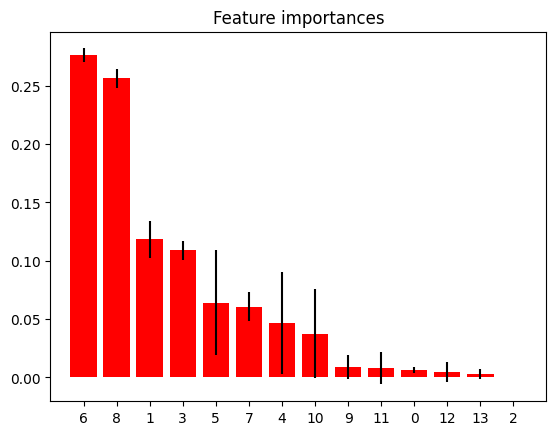

In [74]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
df = pd.DataFrame()
for i, j in zip( x_train_n, forest.feature_importances_ ):
    aux = pd.DataFrame( {'feature': i, 'importance': j}, index=[0] )
    df = pd.concat( [df, aux], axis=0 )
    
print( df.sort_values( 'importance', ascending=False ) )

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(x_train_n.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(x_train_n.shape[1]), indices)
plt.xlim([-1, x_train_n.shape[1]])
plt.show()

## 7.6. - Manual Feature Selection:
The manual selection of features is the selection of the most important columns, defined by boruta, so we don't need to run it again

In [75]:
cols_selected = ['annual_premium', 'vintage', 'age', 'region_code', 'vehicle_damage','policy_sales_channel',  'previously_insured', 'age_insured']

# 8.0. - STEP EIGHT - TRAINING OF MACHINE LEARNING ALGORITHMS
In this step we will train the machine learning algorithms

In [76]:
# Aplicar transformações em x_validation
x_validation = apply_transformations(x_val)

In [77]:
# Dados de Treinamento
x_train = df5[cols_selected]
y_train = y_train  # Mantenha a variável de destino

# Dados de Validação
x_val = x_validation[cols_selected]
y_val = y_val  # Mantenha a variável de destino

## 8.1. - KNN Classifier:

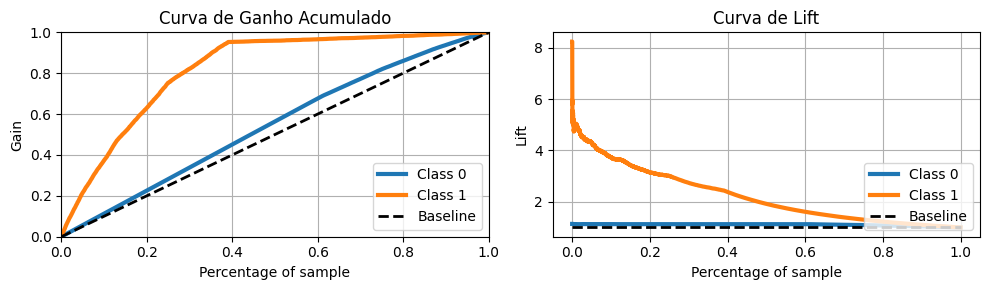

In [78]:
# Criar uma instância do modelo KNeighborsClassifier
knn_model = KNeighborsClassifier(n_neighbors=7)  # Você pode ajustar o valor de 'n_neighbors' conforme necessário

# Treinar o modelo nos dados de treinamento
knn_model.fit(x_train, y_train)

# Fazer previsões de classe nos dados de validação
y_val_pred_knn = knn_model.predict(x_val)

# Fazer previsões de probabilidade nos dados de validação
y_val_prob_knn = knn_model.predict_proba(x_val)

# 'y_val_pred' conterá as classes previstas (0 ou 1) para cada amostra nos dados de validação
# 'y_val_prob' conterá as probabilidades previstas para cada classe (0 e 1) para cada amostra nos dados de validação

# Crie uma figura com dois subplots lado a lado
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))

# Plot da Curva de Ganho Acumulado no primeiro subplot
skplt.metrics.plot_cumulative_gain(y_val, y_val_prob_knn, ax=ax1)
ax1.set_title("Curva de Ganho Acumulado")

# Plot da Curva de Lift no segundo subplot
skplt.metrics.plot_lift_curve(y_val, y_val_prob_knn, ax=ax2)
ax2.set_title("Curva de Lift")

# Ajuste o layout e mostre os gráficos
plt.tight_layout()
plt.show()

Classification Metrics:
Accuracy: 0.8810429545094309
Balanced Accuracy: 0.5920038510452811
Kappa Score: 0.24796904365324002
Precision Score: 0.5240032546786005
Recall Score: 0.21038876184253513
F1 Score: 0.30023310023310024
Matthew Correlation Score: 0.27909663042424476

Ranking Metrics:
ROC AUC: 0.5920038510452811
Top K Score: 0.8810429545094309


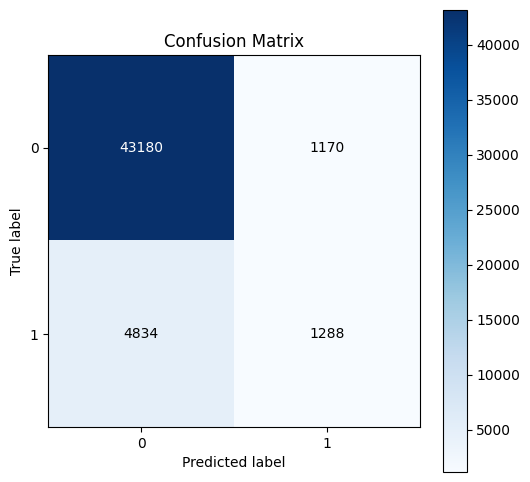

In [79]:
model = knn_model 
classification_metrics = calculate_classification_and_ranking_metrics(model, x_val, y_val, y_val_prob=y_val_prob_knn)

### 8.1.1 - Cross Validation - KNN Classifier

In [80]:
knn_model_cv = cross_validate(knn_model, x_train, y_train, num_folds=5)
knn_model_cv 

{'Accuracy': 0.8621208906884748,
 'Balanced Accuracy': 0.5500997766637516,
 'Kappa Score': 0.13360741859654773,
 'Precision Score': 0.33049177813576985,
 'Recall Score': 0.13876530833412246,
 'F1 Score': 0.19541931490179182,
 'Matthew Correlation Score': 0.1487836216211329,
 'ROC AUC': 0.7897401224611078}

## 8.2. Logistic Regression

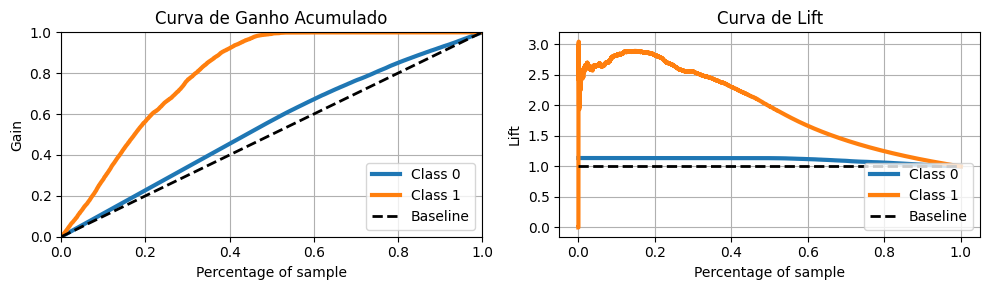

In [81]:
# Criar uma instância do modelo LogisticRegression
logistic_model = LogisticRegression( random_state=42)

# Treinar o modelo nos dados de treinamento
logistic_model.fit(x_train, y_train)

# Fazer previsões de classe nos dados de validação
y_val_pred_logistic = logistic_model.predict(x_val)

# Fazer previsões de probabilidade nos dados de validação
y_val_prob_logistic = logistic_model.predict_proba(x_val)

# 'y_val_pred_logistic' conterá as classes previstas (0 ou 1) para cada amostra nos dados de validação
# 'y_val_prob_logistic' conterá as probabilidades previstas para cada classe (0 e 1) para cada amostra nos dados de validação

# Crie uma figura com dois subplots lado a lado
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))

# Plot da Curva de Ganho Acumulado no primeiro subplot
skplt.metrics.plot_cumulative_gain(y_val, y_val_prob_logistic, ax=ax1)
ax1.set_title("Curva de Ganho Acumulado")

# Plot da Curva de Lift no segundo subplot
skplt.metrics.plot_lift_curve(y_val, y_val_prob_logistic, ax=ax2)
ax2.set_title("Curva de Lift")

# Ajuste o layout e mostre os gráficos
plt.tight_layout()
plt.show()


Classification Metrics:
Accuracy: 0.8786852116024727
Balanced Accuracy: 0.49998872604284106
Kappa Score: -3.9621029320091594e-05
Precision Score: 0.0
Recall Score: 0.0
F1 Score: 0.0
Matthew Correlation Score: -0.001653784418161056

Ranking Metrics:
ROC AUC: 0.49998872604284106
Top K Score: 0.8786852116024727


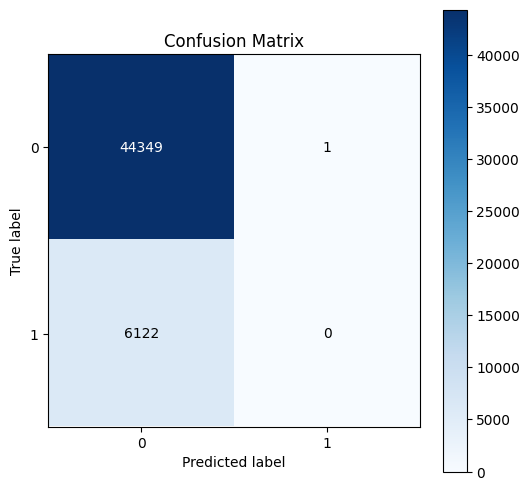

In [82]:
model = logistic_model 
classification_metrics = calculate_classification_and_ranking_metrics(model, x_val, y_val, y_val_prob=y_val_prob_logistic)

### 8.2.1 - Cross Validation - Logistic Regression Classifier

In [83]:
logistic_model_cv = cross_validate(logistic_model, x_train, y_train, num_folds=5)
logistic_model_cv 

{'Accuracy': 0.8792740496701494,
 'Balanced Accuracy': 0.5000325798595053,
 'Kappa Score': 0.00011455312515704641,
 'Precision Score': 0.26666666666666666,
 'Recall Score': 8.205969929400376e-05,
 'F1 Score': 0.00016405210205948213,
 'Matthew Correlation Score': 0.0034424180671932757,
 'ROC AUC': 0.8429227004301681}

## 8.3. LGBM Classifier

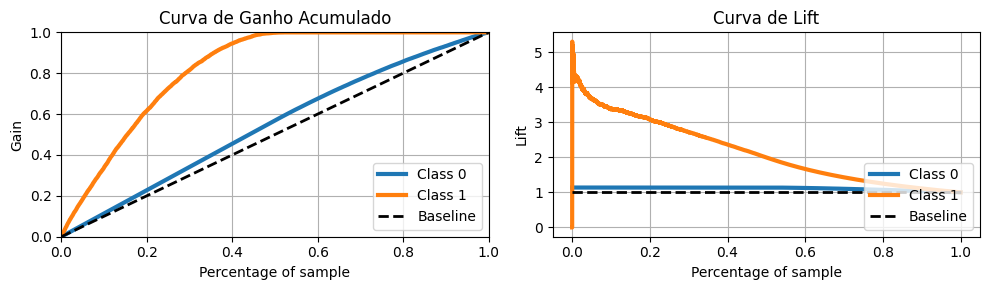

In [84]:
lgbm_model = LGBMClassifier(force_row_wise=True, verbose=-1) # Criar uma instância do modelo LGBMClassifier

# Treinar o modelo nos dados de treinamento
lgbm_model.fit(x_train, y_train)

# Fazer previsões de classe nos dados de validação
y_val_pred_lgbm = lgbm_model.predict(x_val)

# Fazer previsões de probabilidade nos dados de validação (se necessário)
y_val_prob_lgbm = lgbm_model.predict_proba(x_val)

# Crie uma figura com dois subplots lado a lado
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))

# Plot da Curva de Ganho Acumulado no primeiro subplot
skplt.metrics.plot_cumulative_gain(y_val, y_val_prob_lgbm, ax=ax1)
ax1.set_title("Curva de Ganho Acumulado")

# Plot da Curva de Lift no segundo subplot
skplt.metrics.plot_lift_curve(y_val, y_val_prob_lgbm, ax=ax2)
ax2.set_title("Curva de Lift")

# Ajuste o layout e mostre os gráficos
plt.tight_layout()
plt.show()

Classification Metrics:
Accuracy: 0.8788437153273102
Balanced Accuracy: 0.5018388851710079
Kappa Score: 0.006429147918896483
Precision Score: 0.5813953488372093
Recall Score: 0.004083632799738647
F1 Score: 0.008110300081102998
Matthew Correlation Score: 0.04115320608782438

Ranking Metrics:
ROC AUC: 0.501838885171008
Top K Score: 0.8788437153273102


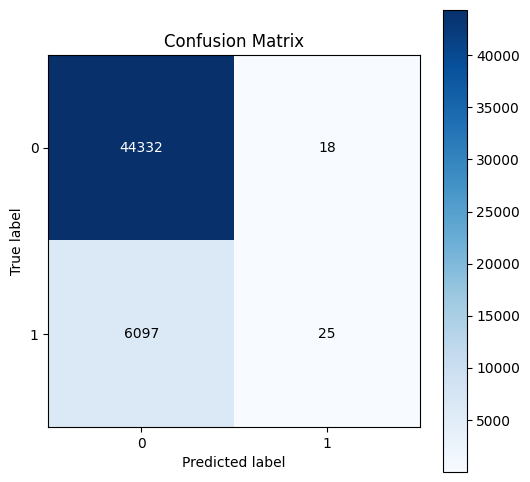

In [85]:
model = lgbm_model 
classification_metrics = calculate_classification_and_ranking_metrics(model, x_val, y_val, y_val_prob=y_val_prob_lgbm)

### 8.3.1 - Cross Validation - LGBM Classifier

In [86]:
lgbm_model_cv = cross_validate(lgbm_model, x_train, y_train, num_folds=5)
lgbm_model_cv 

{'Accuracy': 0.8791601236703572,
 'Balanced Accuracy': 0.5011890376663252,
 'Kappa Score': 0.004160023167438931,
 'Precision Score': 0.457483511296516,
 'Recall Score': 0.0029132413749565983,
 'F1 Score': 0.005784942212209769,
 'Matthew Correlation Score': 0.02789861381765545,
 'ROC AUC': 0.8610169132843893}

## 8.4. Random Forest Classifier


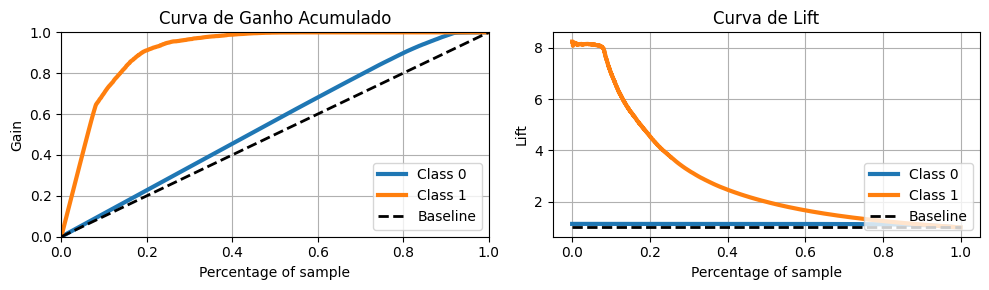

In [87]:
rf_model = RandomForestClassifier( n_estimators=1000, n_jobs=-1, random_state=42 ).fit(x_train, y_train)

# Fazer previsões de classe nos dados de validação
y_val_pred_rf = rf_model.predict(x_val)

# Fazer previsões de probabilidade nos dados de validação (se necessário)
y_val_prob_rf = rf_model.predict_proba(x_val)

# Crie uma figura com dois subplots lado a lado
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))

# Plot da Curva de Ganho Acumulado no primeiro subplot
skplt.metrics.plot_cumulative_gain(y_val, y_val_prob_rf, ax=ax1)
ax1.set_title("Curva de Ganho Acumulado")

# Plot da Curva de Lift no segundo subplot
skplt.metrics.plot_lift_curve(y_val, y_val_prob_rf, ax=ax2)
ax2.set_title("Curva de Lift")

# Ajuste o layout e mostre os gráficos
plt.tight_layout()
plt.show()

Classification Metrics:
Accuracy: 0.9510223490252021
Balanced Accuracy: 0.8335157398953338
Kappa Score: 0.7437944037489309
Precision Score: 0.8919673539518901
Recall Score: 0.6783730806925842
F1 Score: 0.770643904249397
Matthew Correlation Score: 0.7525315877127564

Ranking Metrics:
ROC AUC: 0.8335157398953338
Top K Score: 0.9510223490252021


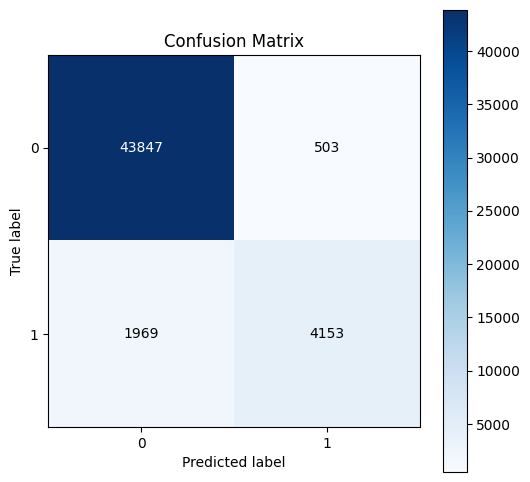

In [88]:
model = rf_model 
classification_metrics = calculate_classification_and_ranking_metrics(rf_model, x_val, y_val, y_val_prob=y_val_prob_rf)

### 8.4.1 - Cross Validation - Random Forest Classifier

In [89]:
rf_model_cv = cross_validate(rf_model, x_train, y_train, num_folds=5)
rf_model_cv 

{'Accuracy': 0.8679756546812379,
 'Balanced Accuracy': 0.5444913350137999,
 'Kappa Score': 0.1251774102250651,
 'Precision Score': 0.3582656614647888,
 'Recall Score': 0.11804500278821166,
 'F1 Score': 0.17754103440599456,
 'Matthew Correlation Score': 0.1483475574850322,
 'ROC AUC': 0.8409006985218198}

## 8.5. XGBoost Classifier

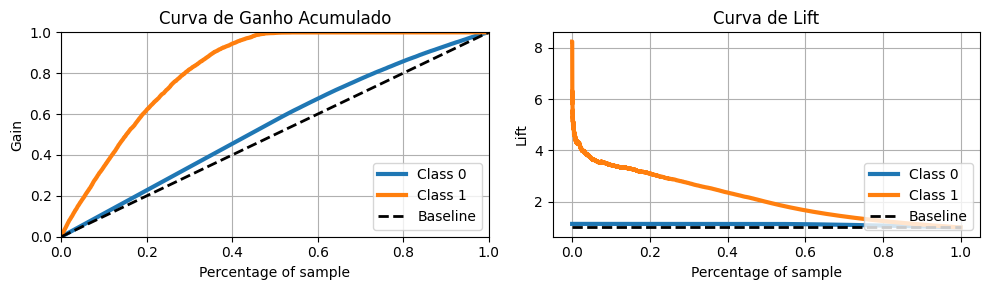

In [90]:
# Criar uma instância do modelo XGBClassifier
xgb_model = XGBClassifier(
    objective='binary:logistic',  # Para problemas de classificação binária
    eval_metric='auc',  # Métrica de avaliação (ROC AUC)
    n_estimators=100,  # Número de árvores (pode ajustar conforme necessário)
    max_depth=6,  # Profundidade máxima da árvore (pode ajustar conforme necessário)
    learning_rate=0.1,  # Taxa de aprendizado (pode ajustar conforme necessário)
    random_state=42  # Seed para reprodutibilidade
)

# Treinar o modelo nos dados de treinamento
xgb_model.fit(x_train, y_train)

# Fazer previsões de classe nos dados de validação
y_val_pred_xgb = xgb_model.predict(x_val)

# Fazer previsões de probabilidade nos dados de validação
y_val_prob_xgb = xgb_model.predict_proba(x_val)

# Crie uma figura com dois subplots lado a lado
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))

# Plot da Curva de Ganho Acumulado no primeiro subplot
skplt.metrics.plot_cumulative_gain(y_val, y_val_prob_xgb, ax=ax1)
ax1.set_title("Curva de Ganho Acumulado")

# Plot da Curva de Lift no segundo subplot
skplt.metrics.plot_lift_curve(y_val, y_val_prob_xgb, ax=ax2)
ax2.set_title("Curva de Lift")

# Ajuste o layout e mostre os gráficos
plt.tight_layout()
plt.show()

Classification Metrics:
Accuracy: 0.8790814709145665
Balanced Accuracy: 0.5027485583441095
Kappa Score: 0.009597754412809745
Precision Score: 0.6792452830188679
Recall Score: 0.005880431231623653
F1 Score: 0.011659919028340082
Matthew Correlation Score: 0.0554106675097314

Ranking Metrics:
ROC AUC: 0.5027485583441095
Top K Score: 0.8790814709145665


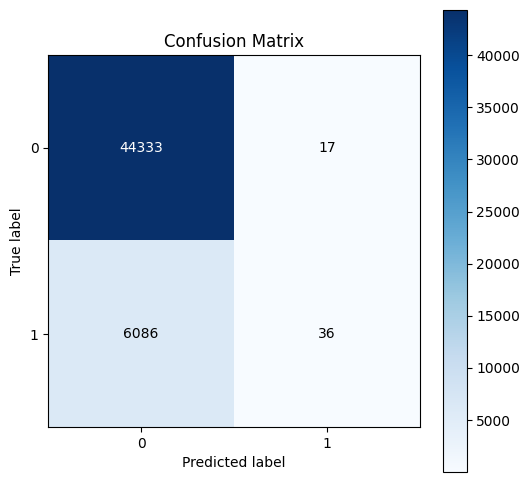

In [91]:
model = xgb_model
classification_metrics = calculate_classification_and_ranking_metrics(xgb_model, x_val, y_val, y_val_prob=y_val_prob_xgb)

### 8.5.1 - Cross Validation - XGBoost Classifier

In [92]:
xgb_model_cv = cross_validate(xgb_model, x_train, y_train, num_folds=5)
xgb_model_cv 

{'Accuracy': 0.8793483487818724,
 'Balanced Accuracy': 0.5021810302417684,
 'Kappa Score': 0.007613955172719145,
 'Precision Score': 0.5307535014005602,
 'Recall Score': 0.004964826446976631,
 'F1 Score': 0.009832664470574872,
 'Matthew Correlation Score': 0.04201166203371924,
 'ROC AUC': 0.8612231909181498}

## 8.6. Performance Metrics Models

In [93]:
# Inicialize os modelos
models = [
    ("KNN Classifier", KNeighborsClassifier(n_neighbors=7)),
    ("Logistic Regression", LogisticRegression()),
    ("LGBM Classifier", LGBMClassifier(force_row_wise=True, verbose=-1)),
    ("Random Forest Classifier", RandomForestClassifier( n_estimators=1000, n_jobs=-1, random_state=42 )),
    ("XGBoost Classifier", XGBClassifier(objective='binary:logistic', eval_metric='auc', n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42))
]

# Inicialize um DataFrame para armazenar as métricas
metrics_df = pd.DataFrame(columns=["Model", "Accuracy", "Precision", "Recall", "F1 Score", "AUC-ROC"])

# Loop através dos modelos
for model_name, model in models:
    # Treine o modelo
    model.fit(x_train, y_train)
    
    # Faça previsões no conjunto de validação
    y_pred = model.predict(x_val)
    y_prob = model.predict_proba(x_val)[:, 1]  # Probabilidade da classe positiva
    
    # Calcule as métricas
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    auc_roc = roc_auc_score(y_val, y_prob)
    
    # Adicione as métricas ao DataFrame
    metrics_df.loc[len(metrics_df)] = [model_name, accuracy, precision, recall, f1, auc_roc]

# Exiba a tabela comparativa
metrics_df

,Model,Accuracy,Precision,Recall,F1 Score,AUC-ROC
0,KNN Classifier,0.8810,0.5240,0.2104,0.3002,0.8657
1,Logistic Regression,0.8787,0.0000,0.0000,0.0000,0.8462
2,LGBM Classifier,0.8788,0.5814,0.0041,0.0081,0.8701
3,Random Forest Classifier,0.9510,0.8920,0.6784,0.7706,0.9705
4,XGBoost Classifier,0.8791,0.6792,0.0059,0.0117,0.8709


### 8.6.1 Cross Validation Performance Models

In [94]:
# Defina o número de folds (k)
num_folds = 5

# Crie um objeto StratifiedKFold para estratificar os folds com base nas classes
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Lista para armazenar as métricas de desempenho para cada modelo
model_metrics = []

# Lista de modelos treinados (substitua com seus modelos)
trained_models = [knn_model, logistic_model, lgbm_model, rf_model, xgb_model]

# Métricas que você deseja calcular
metrics = {
    'Accuracy': accuracy_score,
    'Precision': precision_score,
    'Recall': recall_score,
    'F1 Score': f1_score,
    'AUC-ROC': roc_auc_score
}

# Loop através de cada modelo treinado
for model in trained_models:
    model_name = model.__class__.__name__
    
    # Execute a validação cruzada para o modelo atual
    y_pred = cross_val_predict(model, x_train, y_train, cv=stratified_kfold, method='predict_proba')
    y_prob = y_pred[:, 1]  # Probabilidades da classe positiva
    
    # Calcule as métricas de desempenho para cada fold
    fold_metrics = {}
    for metric_name, metric_func in metrics.items():
        if metric_name == 'AUC-ROC':
            metric_value = metric_func(y_train, y_prob)
        else:
            metric_value = metric_func(y_train, (y_prob > 0.5).astype(int))
        fold_metrics[metric_name] = metric_value
    
    # Adicione as métricas ao modelo atual na lista
    model_metrics.append({
        'Model': model_name,
        **fold_metrics
    })

# Crie um DataFrame com as métricas de desempenho
model_metrics_df = pd.DataFrame(model_metrics)

# Exiba as métricas de desempenho
model_metrics_df

,Model,Accuracy,Precision,Recall,F1 Score,AUC-ROC
0,KNeighborsClassifier,0.8621,0.3307,0.1388,0.1955,0.7897
1,LogisticRegression,0.8793,0.4000,0.0001,0.0002,0.8428
2,LGBMClassifier,0.8792,0.4277,0.0029,0.0058,0.8609
3,RandomForestClassifier,0.8680,0.3580,0.1180,0.1775,0.8409
4,XGBClassifier,0.8793,0.5307,0.0050,0.0098,0.8611


# 9.0. - STEP NINE - FINE TUNING
In this step, we focus on improving the models' performance by fine-tuning their hyperparameters. This process involves searching for the best combination of hyperparameters that optimize the models' performance on the training data. Fine-tuning is essential to achieve better accuracy and generalization on unseen data.

## 9.1. - Random Search:
Random Search, we will perform hyperparameter tuning using the Random Search technique. Random Search is a hyperparameter optimization method that randomly samples hyperparameter combinations from a predefined search space. It is an efficient way to explore a wide range of hyperparameter values without trying all possible combinations.

### 9.1.1 - Random Search: Fine-Tuning para Logistic Regression:

In [95]:
# # Defina a grade de hiperparâmetros que deseja pesquisar
# param_grid = {
#     'C': loguniform(1e-6, 1e+6),  # Parâmetro de regularização
#     'penalty': ['l1', 'l2'],  # Tipo de regularização
# }

# # Crie uma instância do modelo Logistic Regression
# logistic_regression = LogisticRegression(random_state=42, max_iter=1000)

# # Realize a pesquisa aleatória
# logistic_search = RandomizedSearchCV(
#     logistic_regression, param_distributions=param_grid,
#     n_iter=5,  # Número de iterações
#     scoring='roc_auc',  # Métrica de avaliação
#     cv=5,  # Número de dobras para validação cruzada
#     random_state=42
# )

# # Execute a pesquisa aleatória nos dados de treinamento
# logistic_search.fit(x_train, y_train)

# # Exiba os melhores hiperparâmetros encontrados
# print("Melhores Hiperparâmetros para Logistic Regression:", logistic_search.best_params_)

### 9.1.2 - Random Search: Fine-Tuning para LightGBM

In [96]:
# # Defina a grade de hiperparâmetros que deseja pesquisar
# param_grid = {
#     'n_estimators': [100, 200, 300],  # Número de árvores
#     'learning_rate': uniform(0.01, 0.1),  # Taxa de aprendizado
#     'max_depth': [5, 10, 15],  # Profundidade máxima da árvore
# }

# # Crie uma instância do modelo LightGBM
# lgbm_model = LGBMClassifier(random_state=42, force_row_wise=True, verbose=-1)

# # Realize a pesquisa aleatória
# lgbm_search = RandomizedSearchCV(
#     lgbm_model, param_distributions=param_grid,
#     n_iter=5,  # Número de iterações
#     scoring='roc_auc',  # Métrica de avaliação
#     cv=5,  # Número de dobras para validação cruzada
#     random_state=42
# )

# # Execute a pesquisa aleatória nos dados de treinamento
# lgbm_search.fit(x_train, y_train)

# # Exiba os melhores hiperparâmetros encontrados
# print("Melhores Hiperparâmetros para LightGBM:", lgbm_search.best_params_)

### 9.1.3 - Random Search: Fine-Tuning para XGBoost Classifier

In [97]:
# # Defina a grade de hiperparâmetros que deseja pesquisar
# param_grid = {
#     'n_estimators': [80, 100, 150, 200, 500, 1500, 2500, 3500],
#     'eta': [0.01, 0.03],
#     'max_depth': [3, 5, 9],
#     'subsample': [0.1, 0.5, 0.7],
#     'colsample_bytree': [0.3, 0.7, 0.9]
# }

# # Crie uma instância do modelo XGBoost Classifier
# xgb_model = XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=42)

# # Realize a pesquisa aleatória
# xgb_search = RandomizedSearchCV(
#     xgb_model, param_distributions=param_grid,
#     n_iter=5,  # Número de iterações
#     scoring='roc_auc',  # Métrica de avaliação
#     cv=5,  # Número de dobras para validação cruzada
#     verbose=2,  # Exiba informações detalhadas durante a busca
#     random_state=42,
#     n_jobs=-1  # Use todos os núcleos da CPU para acelerar a busca
# )

# # Execute a pesquisa aleatória nos dados de treinamento
# xgb_search.fit(x_train, y_train)

# # Exiba os melhores hiperparâmetros encontrados
# print("Melhores Hiperparâmetros para XGBoost Classifier:", xgb_search.best_params_)


### 9.1.4 - Random Search: Fine-Tuning para Random Forest Classifier

In [98]:
# # Defina a grade de hiperparâmetros que deseja pesquisar
# param_grid = {
#     'n_estimators': [100, 200, 300, 500, 1000],  # Número de árvores na floresta
#     'max_depth': [None, 10, 20, 30],  # Profundidade máxima da árvore
#     'min_samples_split': [2, 5, 10],  # Número mínimo de amostras para dividir um nó
#     'min_samples_leaf': [1, 2, 4],  # Número mínimo de amostras em uma folha
#     'max_features': ['auto', 'sqrt', 'log2']  # Número máximo de recursos a considerar em cada divisão
# }

# # Crie uma instância do modelo Random Forest Classifier
# rf_model = RandomForestClassifier(random_state=42)

# # Realize a pesquisa aleatória
# rf_search = RandomizedSearchCV(
#     rf_model, param_distributions=param_grid,
#     n_iter=5,  # Número de iterações
#     scoring='roc_auc',  # Métrica de avaliação
#     cv=5,  # Número de dobras para validação cruzada
#     random_state=42
# )

# # Execute a pesquisa aleatória nos dados de treinamento
# rf_search.fit(x_train, y_train)

# # Exiba os melhores hiperparâmetros encontrados
# print("Melhores Hiperparâmetros para Random Forest Classifier:", rf_search.best_params_)

### 9.1.5 - Random Search: Fine-Tuning para K-Nearest Neighbors (KNN) Classifier

In [99]:
# # Defina a grade de hiperparâmetros que deseja pesquisar
# param_grid = {
#     'n_neighbors': [3, 5, 7],  # Número de vizinhos
#     'weights': ['uniform', 'distance'],  # Peso dos vizinhos
#     'p': [1, 2],  # Parâmetro para a distância de Minkowski (1 para Manhattan, 2 para Euclidiana)
# }

# # Crie uma instância do modelo K-Nearest Neighbors (KNN) Classifier
# knn_model = KNeighborsClassifier()

# # Realize a pesquisa aleatória
# knn_search = RandomizedSearchCV(
#     knn_model, param_distributions=param_grid,
#     n_iter=5,  # Número de iterações
#     scoring='roc_auc',  # Métrica de avaliação
#     cv=5,  # Número de dobras para validação cruzada
#     random_state=42
# )

# # Execute a pesquisa aleatória nos dados de treinamento
# knn_search.fit(x_train, y_train)

# # Exiba os melhores hiperparâmetros encontrados
# print("Melhores Hiperparâmetros para K-Nearest Neighbors (KNN) Classifier:", knn_search.best_params_)

## 9.2. - Final Parameters Adopted for Random Forest Classifier:
In this section, you should present the final set of hyperparameters that were selected for the Random Forest Classifier model based on the results of the random search or any other hyperparameter tuning method used.

Razões para uso do RandomForestClassifier:

O modelo performou bem com as métricas padrão e, como o objetivo é criar uma lista de clientes mais propensos a comprar o seguro, o modelo que parece ser mais apropriado é o "RandomForestClassifier":

**Classification Metrics (Métricas de Classificação):**
1. **Accuracy (Acurácia)**: Mede a taxa geral de acerto do modelo, ou seja, a proporção de previsões corretas em relação ao total de previsões. Neste caso, a acurácia é de aproximadamente 95,10%, indicando que o modelo acerta a classificação em cerca de 95,10% das vezes.

2. **Balanced Accuracy (Acurácia Balanceada)**: Leva em consideração o desequilíbrio de classes no conjunto de dados. É útil quando as classes estão desproporcionalmente distribuídas. Neste caso, a acurácia balanceada é de aproximadamente 83,35%, sugerindo que o modelo tem um bom desempenho, considerando o desequilíbrio de classes.

3. **Kappa Score (Índice Kappa)**: Compara o desempenho do modelo com o desempenho esperado ao acaso. Leva em conta o equilíbrio entre previsões corretas e previsões ao acaso. Neste caso, o índice Kappa é de aproximadamente 0,74, indicando um bom desempenho em relação ao acaso.

4. **Precision Score (Precisão)**: Mede a proporção de previsões positivas corretas em relação ao total de previsões positivas feitas pelo modelo. Neste caso, a precisão é de aproximadamente 89,20%, o que indica que, das previsões positivas do modelo, cerca de 89,20% estão corretas.

5. **Recall Score (Revocação ou Sensibilidade)**: Mede a proporção de instâncias positivas corretamente previstas em relação ao total de instâncias positivas no conjunto de dados. Neste caso, a revocação é de aproximadamente 67,84%, indicando que o modelo identificou corretamente cerca de 67,84% das instâncias positivas.

6. **F1 Score**: É a média harmônica entre precisão e revocação. É útil quando se deseja equilibrar precisão e revocação. Neste caso, o F1 Score é de aproximadamente 0,77, sugerindo um bom equilíbrio entre precisão e revocação.

7. **Matthew Correlation Score (Coeficiente de Correlação de Matthews)**: É uma medida do desempenho geral do modelo, considerando verdadeiros positivos, verdadeiros negativos, falsos positivos e falsos negativos. Neste caso, o coeficiente de correlação de Matthews é de aproximadamente 0,75, indicando um bom desempenho geral.

**Ranking Metrics (Métricas de Classificação por Ranking):**
1. **ROC AUC**: A Área sob a Curva ROC (Receiver Operating Characteristic) é uma métrica que avalia a capacidade do modelo de distinguir entre classes positivas e negativas. Neste caso, a ROC AUC é de aproximadamente 83,35%, indicando um bom desempenho na diferenciação entre as classes.

2. **Top K Score**: Mede o desempenho do modelo em relação aos K principais resultados. Neste caso, o Top K Score é de aproximadamente 95,10%, indicando que o modelo tem um bom desempenho na classificação das principais previsões.

Em resumo, as métricas indicam que o modelo tem um desempenho geral muito bom, com alta precisão e revocação, além de uma boa capacidade de diferenciação entre classes. O índice Kappa também sugere que o desempenho é significativamente melhor do que o esperado ao acaso.

In [100]:
# Modelo final com os melhores hiperparâmetros
rf_model_bp = RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=42)

# Treine o modelo final com todos os dados de treinamento (treinamento + validação)
x_train_final = pd.concat([x_train, x_val])
y_train_final = pd.concat([y_train, y_val])

rf_model_bp.fit(x_train_final, y_train_final)

RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=42)

In [101]:
# # Salve o dicionário do modelo em um arquivo pickle
# with open('../propensity_score/rf_model_bp.pkl', 'wb') as file:
#     pickle.dump(rf_model_bp, file)

# 10.0. - STEP TEN - TRANSLATION AND INTERPRETATION OF THE ERROR FOR THE BUSINESS TEAM
In this step, the goal is to translate and interpret the error metrics calculated during the evaluation of the models for the business team.

In [102]:
# Aplicando as transformações no conjunto de teste
x_testing = apply_transformations(x_test)

In [103]:
x_test = x_testing[cols_selected]

In [104]:
# Fazer previsões de classe nos dados de teste
y_test_pred_rf = rf_model_bp.predict(x_test)

# Fazer previsões de probabilidade nos dados de teste (se necessário)
y_test_prob_rf = rf_model_bp.predict_proba(x_test)

# Avalie o desempenho do modelo final nos dados de teste
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

accuracy = accuracy_score(y_test, y_test_pred_rf)
precision = precision_score(y_test, y_test_pred_rf)
recall = recall_score(y_test, y_test_pred_rf)
f1 = f1_score(y_test, y_test_pred_rf)
roc_auc = roc_auc_score(y_test, y_test_prob_rf[:, 1])  # Use as probabilidades da classe positiva

print("Desempenho do Modelo Final nos Dados de Teste:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

Desempenho do Modelo Final nos Dados de Teste:
Accuracy: 0.8894
Precision: 0.5892
Recall: 0.2759
F1 Score: 0.3758
ROC AUC: 0.8842


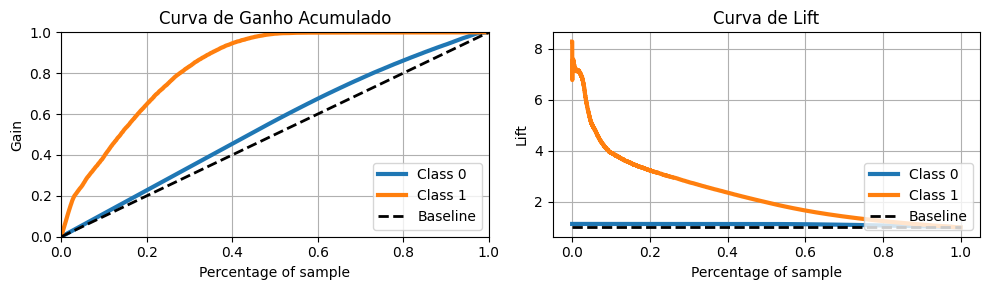

In [105]:
# Crie uma figura com dois subplots lado a lado
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))

# Plot da Curva de Ganho Acumulado no primeiro subplot
skplt.metrics.plot_cumulative_gain(y_test, y_test_prob_rf, ax=ax1)
ax1.set_title("Curva de Ganho Acumulado")

# Plot da Curva de Lift no segundo subplot
skplt.metrics.plot_lift_curve(y_test, y_test_prob_rf, ax=ax2)
ax2.set_title("Curva de Lift")

# Ajuste o layout e mostre os gráficos
plt.tight_layout()
plt.show()

In [106]:
# Crie um novo DataFrame com as probabilidades previstas e os rótulos reais nos dados de teste
df_results = x_test.copy()
df_results['response'] = y_test  # Adicione os rótulos reais
df_results['predicted_prob'] = y_test_prob_rf[:, 1]  # Use as probabilidades previstas do modelo final

# Ordene o DataFrame por probabilidades previstas em ordem decrescente
df_results = df_results.sort_values(by='predicted_prob', ascending=False)

# Determine o valor de K como 50% dos clientes com maiores probabilidades
K = int(0.50 * len(df_results))

# Selecione os top-K clientes
top_K_customers = df_results.head(K)

# Calcule a precisão no top-K
precision = top_K_customers['response'].sum() / K

# Calcule o recall no top-K
total_actual_purchases = df_results['response'].sum()
recall = top_K_customers['response'].sum() / total_actual_purchases

print(f'Precision at K: {precision:.4f}')
print(f'Recall at K: {recall:.4f}')

Precision at K: 0.2399
Recall at K: 0.9936


As métricas Precision at K e Recall at K revelam a eficácia do modelo na identificação de clientes propensos a comprar seguro de automóvel. A Precision at K indica que aproximadamente 23,99% dos K clientes de maior probabilidade realmente adquirem o seguro quando contatados pelo time de vendas. Enquanto isso, o Recall at K é notavelmente alto em 0,9936, indicando que a maioria dos compradores reais está entre os top-K clientes com maiores probabilidades previstas. Embora o modelo seja eficaz em identificar compradores em potencial, a precisão pode ser aprimorada, sugerindo a oportunidade de refinar a seleção de clientes a serem contatados e, assim, otimizar a conversão de vendas.

## 10.1. - Evaluating Model Overestimation or Underestimation of the final model in Test:
In this section, the code aims to evaluate whether the final model tends to overestimate or underestimate.

In [107]:
# Calcular a diferença entre as probabilidades previstas e a taxa real de compra do seguro
df_results['prob_diff'] = df_results['predicted_prob'] - df_results['response']

# Determinar se o modelo está superestimando ou subestimando
df_results['estimation'] = np.where(df_results['prob_diff'] > 0, 'Superestimando', 'Subestimando')

# Contar quantas vezes o modelo superestimou e subestimou
estimation_counts = df_results['estimation'].value_counts()

# Exibir os resultados
print("Contagem de Superestimação e Subestimação:")
print(estimation_counts)

Contagem de Superestimação e Subestimação:
estimation
Subestimando      33795
Superestimando    29295
Name: count, dtype: int64


O modelo subestimou cerca de 33.795 vezes e superestimou cerca de 29.295 vezes. A diferença entre essas contagens indica que o modelo está inclinado a fazer previsões mais conservadoras, subestimando com mais frequência do que superestimando.

Isso significa que o modelo previu uma probabilidade menor de compra do seguro do que a taxa real de compra do seguro. Em outras palavras, o modelo tende a ser mais conservador em suas previsões, prevendo menos compras do que realmente acontecem. É preferível subestimar a probabilidade de um evento para evitar ações desnecessárias ou custos adicionais para a equipe de marketing.

Dada a pequena diferença entre ambas as contagens e o problema de negócio enfrentado, pode-se considerar que o modelo está se saindo bem.

## 10.2. - Respondendo as pergunta de negócio:

### 10.2.1. - Fazendo upload do conjunto de teste e determinando o melhor threshold para o modelo

In [108]:
df_test = pd.read_csv( '../propensity_score/data/raw/test.csv' )

In [109]:
df_test = apply_transformations(df_test)

In [110]:
df_test = feature_engineering(df_test)

In [111]:
df_test = df_test[cols_selected]

In [112]:
# Valores de threshold que você deseja testar
thresholds = [0.1, 0.2, 0.25, 0.3, 0.35, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# Dados reais e probabilidades previstas
y_true = df_results['response']
predicted_probs = df_results['predicted_prob']

# Inicialize as listas para armazenar as métricas
precisions = []
recalls = []
f1_scores = []
roc_aucs = []

# Itere sobre os diferentes valores de threshold
for threshold in thresholds:
    # Converte as probabilidades em previsões binárias com base no threshold
    y_pred = (predicted_probs >= threshold).astype(int)
    
    # Calcule as métricas
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, predicted_probs)
    
    # Armazene as métricas nas listas
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)
    roc_aucs.append(roc_auc)

# Crie um DataFrame para visualizar as métricas para cada threshold
results_df = pd.DataFrame({'Threshold': thresholds,
                           'Precision': precisions,
                           'Recall': recalls,
                           'F1 Score': f1_scores,
                           'ROC AUC': roc_aucs})

# Encontre o threshold que produziu o melhor F1 Score
best_f1_threshold = results_df.loc[results_df['F1 Score'].idxmax()]

print("Resultados da Busca de Thresholds:")
print(results_df)

print("\nMelhor Threshold com Base no F1 Score:")
print(best_f1_threshold)

Resultados da Busca de Thresholds:
    Threshold  Precision  Recall  F1 Score  ROC AUC
0      0.1000     0.3023  0.9143    0.4543   0.8842
1      0.2000     0.3612  0.7528    0.4881   0.8842
2      0.2500     0.3874  0.6598    0.4881   0.8842
3      0.3000     0.4149  0.5645    0.4783   0.8842
4      0.3500     0.4451  0.4706    0.4575   0.8842
5      0.4000     0.4765  0.3863    0.4267   0.8842
6      0.5000     0.5879  0.2767    0.3763   0.8842
7      0.6000     0.7350  0.2109    0.3277   0.8842
8      0.7000     0.8503  0.1417    0.2429   0.8842
9      0.8000     0.8893  0.0358    0.0689   0.8842
10     0.9000     0.8519  0.0030    0.0060   0.8842

Melhor Threshold com Base no F1 Score:
Threshold   0.2500
Precision   0.3874
Recall      0.6598
F1 Score    0.4881
ROC AUC     0.8842
Name: 2, dtype: float64


### 10.2.2. - Principais insights sobre os atributos mais relevantes de clientes interessados em adquirir um seguro de automóvel:

+ Clientes com idades entre 30 e 50 anos têm mais interesse em seguro de veículos.

+ Clientes com carros mais novos têm mais interesse em seguro de veículos.

+ Clientes em regiões específicas têm mais interesse em seguro de veículos.

+ Os atributos mais relevantes para definir o interesse do cliente são (previouslyInsured, annualPremium, vintage, age, regionCode, policySalesChannel, vehicleDamage).

### 10.2.3. - Porcentagem de clientes interessados se o time de vendas conseguir fazer 40.000 ligações:
Ao contatar os clientes com as maiores probabilidades previstas de compra de seguro (usando um threshold de 0.25), o time de vendas conseguirá alcançar aproximadamente 81.79% dos clientes que são considerados interessados em adquirir um seguro de automóvel de acordo com o modelo. Em outras palavras, ao fazer 40.000 ligações para os clientes mais propensos, cerca de 81.79% deles têm uma probabilidade prevista de compra de seguro igual ou maior que 0.25, indicando um alto potencial de conversão. Isso demonstra a eficácia do direcionamento com base nas previsões do modelo para maximizar as chances de sucesso nas vendas. Pelo menos 2,5 vezes mais do que o método aleatório.

In [113]:
# Faça previsões de probabilidade no conjunto de testes
y_test_prob_rf = rf_model_bp.predict_proba(df_test)

In [114]:
calls = 40000
total_leads = df_test.shape[0]
percent_calls = calls / total_leads
print('Insurance All total leads: {}'.format(total_leads))
print('Insurance All % of calls: {0:.2f}%'.format(percent_calls*100))

Insurance All total leads: 127037
Insurance All % of calls: 31.49%


In [115]:
# Defina o número de ligações
num_ligacoes = 40000

# Selecione aleatoriamente K clientes para contatar com base nas probabilidades previstas
# Certifique-se de que K seja menor ou igual ao tamanho do conjunto de testes
K = min(num_ligacoes, len(df_test))

# Ordene o DataFrame de testes com base nas probabilidades previstas em ordem decrescente
df_test_results = df_test.copy()
df_test_results['predicted_prob'] = y_test_prob_rf[:, 1]
df_test_results = df_test_results.sort_values(by='predicted_prob', ascending=False)

# Selecione os top-K clientes para contatar
top_K_to_contact = df_test_results.head(K)

# Calcule a porcentagem de clientes interessados entre os contatados
porcentagem_interessados_contatados = (top_K_to_contact['predicted_prob'] >= 0.25).mean() * 100

print(f'Porcentagem de Clientes Interessados Contatados: {porcentagem_interessados_contatados:.2f}%')

Porcentagem de Clientes Interessados Contatados: 81.79%


### 10.2.4. - Quantas ligações o time de vendas precisa fazer para contatar 80% dos clientes interessados em adquirir um seguro de automóvel:

In [116]:
# Defina a porcentagem desejada de clientes interessados a serem contatados
porcentagem_desejada = 80  # Porcentagem desejada (80%)

# Ordene o DataFrame de teste com base nas probabilidades previstas em ordem decrescente
df_test_results = df_test.copy()
df_test_results['predicted_prob'] = y_test_prob_rf[:, 1]
df_test_results = df_test_results.sort_values(by='predicted_prob', ascending=False)

# Calcule o número total de clientes interessados no conjunto de teste (threshold >= 0.25)
total_clientes_interessados = (df_test_results['predicted_prob'] >= 0.25).sum()

# Calcule o número de ligações necessário para atingir a porcentagem desejada
num_ligacoes_necessarias = (porcentagem_desejada / 100) * total_clientes_interessados

print(f"Número de Ligações Necessárias para Contatar {porcentagem_desejada}% dos Clientes Interessados: {int(num_ligacoes_necessarias)}")

Número de Ligações Necessárias para Contatar 80% dos Clientes Interessados: 26172


## 10.1. - Business Performance:
In this section, we perform an analysis of the business performance based on the model's predictions.

In [117]:
# Você deve adaptar o código abaixo para a maneira como carrega seus dados originais
original_data = pd.read_csv('../propensity_score/data/raw/test.csv')

# Agora, adicione a coluna 'id' de volta ao DataFrame df_test
df_test['id'] = original_data['id']

In [118]:
calls = 20000
total_leads = df_test.shape[0]
percent_calls = calls / total_leads
print('Insurance All total leads: {}'.format(total_leads))
print('Insurance All % of calls: {0:.2f}%'.format(percent_calls * 100))

customer_interesting = pd.DataFrame()
df10 = df_test.copy()

# Remova temporariamente a coluna 'id'
df10.drop('id', axis=1, inplace=True)

# Faça a previsão
df10['response'] = rf_model_bp.predict_proba(df10)[:, 1]

# Adicione a coluna 'id' de volta
df10['id'] = df_test['id']

probas = [df10['response']]
customer_interesting = topK_performance(df10, probas, 'response', [percent_calls])
customer_interesting['R$ model'] = customer_interesting['target_at_k'] * 2000
customer_interesting['target_random'] = customer_interesting['perc'] * customer_interesting['target_total']
customer_interesting['R$ random'] = customer_interesting['target_random'] * 2000
customer_interesting['R$ Final'] = customer_interesting['R$ model'] - customer_interesting['R$ random']
customer_interesting['X Final'] = customer_interesting['R$ model'] / customer_interesting['R$ random']

Insurance All total leads: 127037
Insurance All % of calls: 15.74%


In [119]:
customer_interesting

,perc,conversion,target_total,target_at_k,cumulative_gains,revenue,R$ model,target_random,R$ random,R$ Final,X Final
0,0.1574,0.0703,17142.7895,8933.5653,0.5211,17867130.6667,17867130.6667,2698.8656,5397731.2069,12469399.4597,3.3101


Com base nos resultados, o modelo parece ser eficaz em identificar clientes com alta probabilidade de compra de um seguro de automóvel. Usando o modelo para direcionar suas ligações, pode-se esperar uma receita significativamente maior do que se fizesse ligações aleatórias. A receita final estimada é de aproximadamente 12.469.399,46 a mais do que em um cenário aleatório. Portanto, usar o modelo é uma estratégia eficaz para otimizar as vendas de seguros de automóvel.

# 11.0. STEP ELEVEN - DEPLOY MODEL TO PRODUCTION
In this step, we will deploy the trained machine learning model to production so that it can be used for making predictions on new data. Deploying a model to production involves setting up a system or infrastructure that allows the model to receive input data, make predictions, and deliver the results to the end-users.

In [120]:
# import pickle
# # Salve o dicionário do modelo em um arquivo pickle
# with open('rf_model_bp.pkl', 'wb') as file:
#     pickle.dump(rf_model_bp, file)

## 11.1. - Implementing a Insurance class:
To implement the Insurance class, we'll follow the same structure provided above, but now we'll include the Flask app and the necessary methods to make predictions using the trained model. 

In [121]:
import json
import pickle
import pandas as pd
import numpy as np
import inflection
import os 

from sklearn.ensemble     import RandomForestClassifier
from sklearn              import preprocessing   as pp
from lightgbm             import LGBMClassifier
from sklearn              import metrics         as m
from category_encoders    import OneHotEncoder

class HealthInsurance (object):
    
    def __init__( self ):
        # Use o caminho relativo para o diretório do script
        script_dir = os.path.dirname(__file__)  # Obtém o diretório do script atual
        self.home_path = script_dir  # Define o diretório como home_path

        # Use caminhos relativos para carregar os arquivos pickle
        self.gender_label_encoder = pickle.load(open (os.path.join(script_dir, 'parameter/gender_label_encoder.pkl'), 'rb'))
        self.vehicle_damage_label_encoder = pickle.load(open('parameter/vehicle_damage_label_encoder.pkl','rb'))
        self.mms_age = pickle.load(open(os.path.join(script_dir, 'parameter/mms_age_scaler.pkl'), 'rb'))
        self.mms_annual_premium = pickle.load(open(os.path.join(script_dir, 'parameter/annual_premium_scaler.pkl'), 'rb'))
        self.mms_vintage = pickle.load(open(os.path.join(script_dir, 'parameter/vintage_scaler.pkl'), 'rb'))
        self.target_encode_region_code = pickle.load(open(os.path.join(script_dir, 'parameter/target_encode_region_code.pkl'), 'rb'))
        self.fe_policy_sales_channel = pickle.load(open(os.path.join(script_dir, 'parameter/fe_policy_sales_channel_scaler.pkl'), 'rb'))
    
    def data_cleanning(self,df1):
         # Renomeie as colunas para snake_case
        df1.columns = [inflection.underscore(col) for col in df1.columns]
        return df1
                      
    def feature_engieneering(self,df2):
        df2['risk_age']= df2['age'].apply(lambda x: 0 if x>25 else 1)    
        
        df2['age_insured'] = ((df2['age'] >= 32) & (df2['age'] <= 52) & (df2['previously_insured'] == 0)).astype(int)

        return df2
    
    def data_preparation(self,df5):
        # # Carregue os LabelEncoders salvos
        # gender_label_encoder = pickle.load(open('../propensity_score/parameter/gender_label_encoder.pkl', 'rb'))
        # vehicle_damage_label_encoder = pickle.load(open('../propensity_score/parameter/vehicle_damage_label_encoder.pkl', 'rb'))
        # # Carregue os MinMaxScalers salvos
        # mms_age = pickle.load(open('../propensity_score/parameter/mms_age_scaler.pkl', 'rb'))
        # mms_annual_premium = pickle.load(open('../propensity_score/parameter/annual_premium_scaler.pkl', 'rb'))
        # mms_vintage = pickle.load(open('../propensity_score/parameter/vintage_scaler.pkl', 'rb'))
        # # Carregue o dicionário de frequency encoding para 'policy_sales_channel'
        # fe_policy_sales_channel = pickle.load(open('../propensity_score/parameter/fe_policy_sales_channel_scaler.pkl', 'rb'))
        # # Carregue o dicionário de target encoding para 'region_code'
        # target_encode_region_code = pickle.load(open('../propensity_score/parameter/target_encode_region_code.pkl', 'rb'))

        # Aplique o Label Encoding às colunas apropriadas
        df5['gender'] = self.gender_label_encoder.transform(df5['gender'])
        df5['vehicle_damage'] = self.vehicle_damage_label_encoder.transform(df5['vehicle_damage'])

        # Aplique o MinMaxScaler às colunas apropriadas
        df5['age'] = self.mms_age.transform(df5[['age']])
        df5['annual_premium'] = self.mms_annual_premium.transform(df5[['annual_premium']])
        df5['vintage'] = self.mms_vintage.transform(df5[['vintage']])
        
        # Mapeie os valores em 'policy_sales_channel' com base nas frequências relativas
        df5['policy_sales_channel'] = df5['policy_sales_channel'].map(self.fe_policy_sales_channel)

        # Mapeie os valores em 'region_code' com base nas taxas de resposta média
        df5['region_code'] = df5['region_code'].map(self.target_encode_region_code)

        # Crie as colunas one-hot para 'vehicle_age'
        df5['below_1_year'] = df5['vehicle_age'].apply(lambda x: 1 if x == '< 1 Year' else 0)
        df5['between_1_2_year'] = df5['vehicle_age'].apply(lambda x: 1 if x == '1-2 Year' else 0)
        df5['over_2_years'] = df5['vehicle_age'].apply(lambda x: 1 if x == '> 2 Years' else 0)
        df5.drop('vehicle_age', axis=1, inplace=True)

        df5 = df5.fillna(0)

        # Feature Selection
        cols_selected = ['annual_premium', 'vintage', 'age', 'region_code', 'vehicle_damage','policy_sales_channel',  'previously_insured', 'age_insured']
        
        return df5[ cols_selected ]

    def get_prediction(self, model, original_data, test_data):
        # model prediction
        pred = model.predict_proba(test_data)
        
        # Extract the probabilities of the positive class (column 1)
        positive_class_probabilities = pred[:, 1]
        
        # Create a new column 'prediction' in the original data
        original_data['prediction'] = positive_class_probabilities
        
        return original_data.to_json(orient='records', date_format='iso')

## 11.2. - API Handler:
To implement the API Handler, we'll create a new Python script that will allow us to send test data to the API and receive the predictions. This script will simulate making requests to the API and receiving responses.

In [ ]:
import pickle
import pandas as pd
from flask import Flask,request,Response
from healthinsurance import HealthInsurance

model = pickle.load(open('rf_model_bp.pkl','rb'))

app = Flask(__name__)
@app.route('/healthinsurance/predict',methods=['POST'])

def insurance_all_predict():
    test_json = request.get_json()

    if test_json: # there is data
        if isinstance( test_json, dict ): # unique example
            test_raw = pd.DataFrame( test_json, index=[0] )
            
        else: # multiple example
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
            
        # Instantiate Rossmann class
        pipeline = HealthInsurance()
        
        # data cleaning
        df1 = pipeline.data_cleanning( test_raw )
        
        # feature engineering
        df2 = pipeline.feature_engieneering( df1 )
        
        # data preparation
        df3 = pipeline.data_preparation( df2 )
        
        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df3 )
        
        return df_response
    
    else:
        return Response( '{}', status=200, mimetype='application/json' )
    
if __name__ == '__main__':
    app.run('0.0.0.0')

## 11.3. -  API Tester:
In this section, we are creating an API tester code to evaluate the performance of our deployed model. The API tester code sends test data to the API endpoint and retrieves the predictions returned by the model. 

In [ ]:
import requests
import json
import pandas as pd

# loading test dataset
df_test = pd.read_csv( '../propensity_score/data/raw/test.csv' )

# Convert dataframe to JSON
data = json.dumps(df_test.to_dict(orient='records'))

# API Call
# url = 'http://127.0.0.1:5000/healthinsurance/predict'
url = 'https://propensao-compra.onrender.com//healthinsurance/predict'
header = {'Content-type': 'application/json' }

r = requests.post( url, data=data, headers=header )
print( 'Status Code {}'.format( r.status_code ) )

d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )
d1.sort_values( 'prediction', ascending=False ).head()

In [ ]:
import pandas as pd
import numpy as np
import pickle

# Suponha que 'd1' seja o DataFrame resultante da resposta da API
# 'd1' deve conter a coluna 'prediction' com as previsões no formato [probabilidade_classe_0, probabilidade_classe_1]

# Função para reverter as transformações
def revert_transformations(df):
    # Reverter MinMaxScaler para a coluna 'age'
    df['age'] = df['age'] * (max_age - min_age) + min_age
    
    # Reverter Label Encoding para a coluna 'gender'
    df['gender'] = df['gender'].apply(lambda x: 'Male' if x == 1 else 'Female')
    
    # Reverter Label Encoding para a coluna 'vehicle_damage'
    df['vehicle_damage'] = df['vehicle_damage'].apply(lambda x: 'Yes' if x == 1 else 'No')
    
    # Reverter MinMaxScaler para a coluna 'annual_premium'
    mms_annual_premium = pickle.load(open('../compra_propensao/parameter/annual_premium_scaler.pkl', 'rb'))
    df['annual_premium'] = mms_annual_premium.inverse_transform(df[['annual_premium']])

    # Reverter MinMaxScaler para a coluna 'vintage'
    mms_vintage = pickle.load(open('../compra_propensao/parameter/vintage_scaler.pkl', 'rb'))
    df['vintage'] = mms_vintage.inverse_transform(df[['vintage']])

    # Reverter as colunas one-hot para 'vehicle_age'
    df['vehicle_age'] = df.apply(lambda row: '1-2 Year' if row['between_1_2_year'] == 1 else ('> 2 Years' if row['over_2_years'] == 1 else '< 1 Year'), axis=1)
    df.drop(['below_1_year', 'between_1_2_year', 'over_2_years'], axis=1, inplace=True)

    fe_policy_sales_channel = pickle.load(open('../compra_propensao/parameter/fe_policy_sales_channel_scaler.pkl', 'rb'))
    target_encode_region_code = pickle.load(open('../compra_propensao/parameter/target_encode_region_code.pkl', 'rb'))

    return df

# MinMaxScaler - Valores mínimos e máximos da coluna 'age' após a transformação
min_age = 20 
max_age = 85

# Use a função para reverter as transformações
d1_reverted = revert_transformations(d1.copy())  # Certifique-se de copiar o DataFrame original para evitar alterações indesejadas

d1_reverted.head(10) # 'd1_reverted' agora contém os dados revertidos ao estado original